In [50]:
import pickle, pprint
import math
import netCDF4
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import stats
from scipy.ndimage import gaussian_filter
import pandas as pd
from tabulate import tabulate
import xarray as xr
import dask
import seaborn as sns

import matplotlib
from matplotlib.gridspec import GridSpec
from matplotlib import animation
from matplotlib import transforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.image as imag
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as mticker
import types

import matplotlib.transforms as mtrans
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch

import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import csv
import pandas as pd
import os

from mpl_toolkits.basemap import Basemap
bm = Basemap()

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [51]:
def draw_brace(ax, xspan, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin
    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:resolution//2+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = ymin + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', lw=1)

    ax.text((xmax+xmin)/2., ymin+.07*yspan, text, ha='center', va='bottom')

In [52]:
def bottom_offset(self, bboxes, bboxes2):
    bottom = self.axes.bbox.ymin
    self.offsetText.set(va="top", ha="left")
    self.offsetText.set_position(
            (0, bottom - self.OFFSETTEXTPAD * self.figure.dpi / 72.0))


def register_bottom_offset(axis, func):
    axis._update_offset_text_position = types.MethodType(func, axis)

In [53]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

# Figures

In [54]:
SPCAM5_heat_15 = np.load("Compressed_Data/Improved_SPCAM5_15_Min_Interval_Heat.npy")
SPCAM5_moisture_15 = np.load("Compressed_Data/Improved_SPCAM5_15_Min_Interval_Moisture.npy")
SPCAM3_heat_15 = np.load("Compressed_Data/Improved_SPCAM3_15_Min_Interval_Heat.npy")
SPCAM3_moisture_15 = np.load("Compressed_Data/Improved_SPCAM3_15_Min_Interval_Moisture.npy")

SPCAM5_heat_Daily = np.load("Compressed_Data/Improved_Daily_SPCAM5_15_Min_Interval_Heat.npy")
SPCAM5_moisture_Daily = np.load("Compressed_Data/Improved_Daily_SPCAM5_15_Min_Interval_Moistening.npy")

SPCAM5_Xs = np.load("Compressed_Data/X_Coords.npy")
SPCAM5_pband = np.load("Compressed_Data/Z_Coords.npy")
SPCAM3_Xs = np.load("Compressed_Data/SPCAM3_X_Coords.npy")
SPCAM3_pband = np.load("Compressed_Data/SPCAM3_Z_Coords.npy")

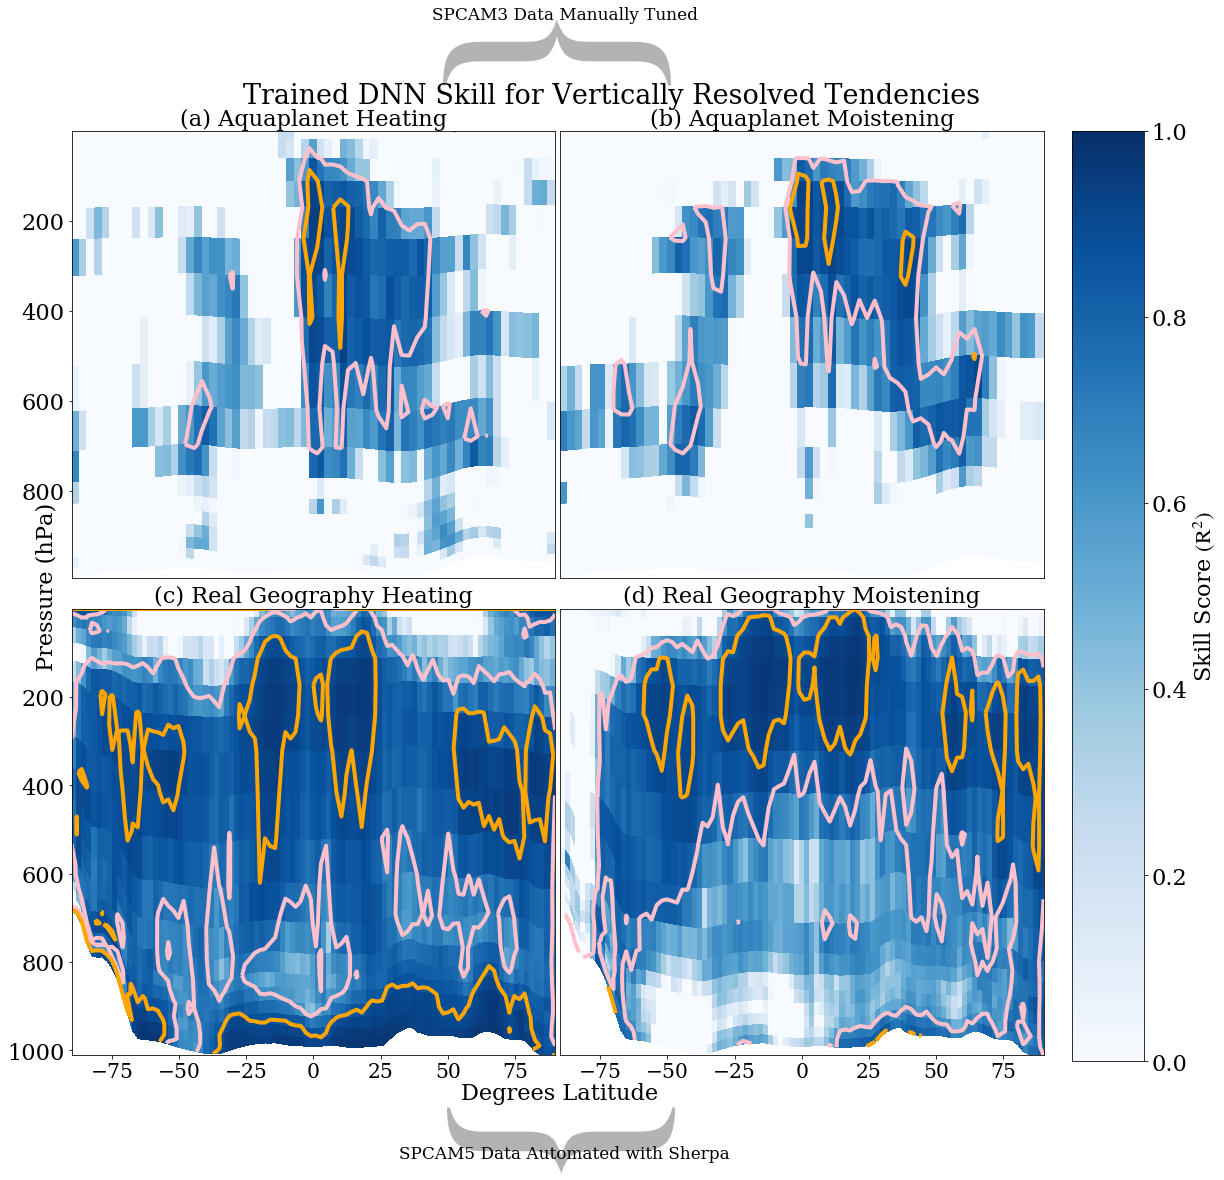

In [55]:

#fig, ax = plt.subplots(2,2, figsize=(15,15))
fig, ax = plt.subplots(2,2, figsize=(20,17))

ax[0,0].pcolor(SPCAM3_Xs, SPCAM3_pband, SPCAM3_heat_15, cmap = 'Blues', vmin = 0, vmax = 1.0)
ax[0,0].contour(SPCAM3_Xs, SPCAM3_pband, SPCAM3_heat_15, [0.7], colors='pink', linewidths=[4])
ax[0,0].contour(SPCAM3_Xs, SPCAM3_pband, SPCAM3_heat_15, [0.9], colors='orange', linewidths=[4])
ax[0,0].set_title("(a) Aquaplanet Heating", fontsize = fz)
ax[0,0].set_ylim(ax[0,0].get_ylim()[::-1])
ax[0,0].set_xticks([])

ax[0,1].pcolor(SPCAM3_Xs, SPCAM3_pband, SPCAM3_moisture_15,  cmap = 'Blues', vmin = 0, vmax = 1.0)
ax[0,1].contour(SPCAM3_Xs, SPCAM3_pband, SPCAM3_moisture_15,  [0.7], colors='pink', linewidths=[4])
ax[0,1].contour(SPCAM3_Xs, SPCAM3_pband, SPCAM3_moisture_15,  [0.9], colors='orange', linewidths=[4])
ax[0,1].set_title("(b) Aquaplanet Moistening", fontsize = fz)
ax[0,1].set_ylim(ax[0,1].get_ylim()[::-1])
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_ylabel("Pressure (hPa)")
ax[0,1].yaxis.set_label_coords(-1.04,-0.02)

ax[1,0].pcolor(SPCAM5_Xs, SPCAM5_pband, SPCAM5_heat_15, cmap = 'Blues', vmin = 0, vmax = 1.0)
ax[1,0].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_heat_15, [0.7], colors='pink', linewidths=[4])
ax[1,0].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_heat_15, [0.9], colors='orange', linewidths=[4])
ax[1,0].set_title("(c) Real Geography Heating", fontsize = fz)
ax[1,0].set_ylim(ax[1,0].get_ylim()[::-1])
ax[1,0].locator_params(nbins=8)
ax[1,0].tick_params(axis='x', labelsize=fz*0.9)

contour_plot = ax[1,1].pcolor(SPCAM5_Xs, SPCAM5_pband, SPCAM5_moisture_15, cmap = 'Blues', vmin = 0, vmax = 1.0)
ax[1,1].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_moisture_15, [0.7], colors='pink', linewidths=[4])
ax[1,1].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_moisture_15, [0.9], colors='orange', linewidths=[4])
ax[1,1].set_title("(d) Real Geography Moistening", fontsize = fz)
ax[1,1].set_ylim(ax[1,1].get_ylim()[::-1])
ax[1,1].set_yticks([])
ax[1,1].set_xlabel("Degrees Latitude")
ax[1,1].xaxis.set_label_coords(-0.0,-0.06)
ax[1,1].locator_params(nbins=8)
ax[1,1].tick_params(axis='x', labelsize=fz*0.9)

trans = ax[0,0].get_xaxis_transform() # x in data untis, y in axes fraction
ax[0,0].annotate(r"$\}$", fontsize=265, alpha=0.3, xy=(40, 1.15), xycoords=trans, rotation=90)
ax[0,0].annotate("SPCAM3 Data Manually Tuned", fontsize=fz*0.75, xy=(43, 1.25), xycoords=trans)

trans = ax[1,1].get_xaxis_transform() # x in data untis, y in axes fraction
ann = ax[1,1].annotate(r"$\}$", fontsize=265, alpha=0.3, xy=(-135, -0.14), xycoords=trans, rotation=270)
ax[1,1].annotate("SPCAM5 Data Automated with Sherpa", fontsize=fz*0.75, xy=(-150, -0.23), xycoords=trans)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.05, 0.76])
fig.colorbar(contour_plot, label="Skill Score "+r'$\left(\mathrm{R^{2}}\right)$', cax=cbar_ax)
plt.suptitle("Trained DNN Skill for Vertically Resolved Tendencies", y = 0.92)
plt.subplots_adjust(hspace=0.07, wspace=0.01)
print(" ")

plt.savefig("Figures/Figure1.png")
plt.savefig("Figures/Figure1.pdf")

In [56]:
z = 30

SPCAM3_heat_15[SPCAM3_heat_15 < 0.0] = 0.0
SPCAM3_heat_15[SPCAM3_heat_15 > 1.0] = 1.0

SPCAM3_moisture_15[SPCAM3_moisture_15 < 0.0] = 0.0
SPCAM3_moisture_15[SPCAM3_moisture_15 > 1.0] = 1.0

SPCAM5_heat_15[SPCAM5_heat_15 < 0.0] = 0.0
SPCAM5_heat_15[SPCAM5_heat_15 > 1.0] = 1.0

SPCAM5_moisture_15[SPCAM5_moisture_15 < 0.0] = 0.0
SPCAM5_moisture_15[SPCAM5_moisture_15 > 1.0] = 1.0

SPCAM3_Heating = np.nanmean(SPCAM3_heat_15, axis = 0)
SPCAM3_Moistening = np.nanmean(SPCAM3_moisture_15, axis = 0)
SPCAM5_Heating = np.nanmean(SPCAM5_heat_15, axis=0)
SPCAM5_Moistening = np.nanmean(SPCAM5_moisture_15, axis=0)
#SPCAM3 
print("SPCAM3 Heat Global 25th Percentile is",np.percentile(SPCAM3_heat_15,25))
print("SPCAM3 Heat Global 50th Percentile is",np.percentile(SPCAM3_heat_15,50))
print("SPCAM3 Heat Global 75th Percentile is",np.percentile(SPCAM3_heat_15,75))

print("SPCAM3 Moist Global 25th Percentile is",np.percentile(SPCAM3_moisture_15 ,25))
print("SPCAM3 Moist Global 50th Percentile is",np.percentile(SPCAM3_moisture_15 ,50))
print("SPCAM3 Moist Global 75th Percentile is",np.percentile(SPCAM3_moisture_15 ,75))

others = netCDF4.Dataset("Compressed_Data/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0001-12-31-00000.nc")
lon_list = np.array(others.variables['lon'])
lat_list = np.array(others.variables['lat'])

print("SPCAM5 Heat Global 25th Percentile is",np.percentile(SPCAM5_heat_15,25))
print("SPCAM5 Heat Global 50th Percentile is",np.percentile(SPCAM5_heat_15,50))
print("SPCAM5 Heat Global 75th Percentile is",np.percentile(SPCAM5_heat_15,75))

print("SPCAM5 Moist Global 25th Percentile is",np.percentile(SPCAM5_moisture_15 ,25))
print("SPCAM5 Moist Global 50th Percentile is",np.percentile(SPCAM5_moisture_15 ,50))
print("SPCAM5 Moist Global 75th Percentile is",np.percentile(SPCAM5_moisture_15 ,75))

SPCAM3 Heat Global 25th Percentile is 0.0
SPCAM3 Heat Global 50th Percentile is 0.0
SPCAM3 Heat Global 75th Percentile is 0.0
SPCAM3 Moist Global 25th Percentile is 0.0
SPCAM3 Moist Global 50th Percentile is 0.0
SPCAM3 Moist Global 75th Percentile is 0.0
SPCAM5 Heat Global 25th Percentile is 0.5872612778982831
SPCAM5 Heat Global 50th Percentile is 0.8015779864514183
SPCAM5 Heat Global 75th Percentile is 0.8983998860564562
SPCAM5 Moist Global 25th Percentile is 0.0
SPCAM5 Moist Global 50th Percentile is 0.2406140877917013
SPCAM5 Moist Global 75th Percentile is 0.7248191734084013


In [57]:
No_SHERPA_SPCAM5_heat_15 = np.load("Compressed_Data/Improved_NO_SHERPA_SPCAM5_15_Min_Interval_Heat.npy")
No_SHERPA_SPCAM5_moist_15 = np.load("Compressed_Data/Improved_NO_SHERPA_SPCAM5_15_Min_Interval_Moisture.npy")

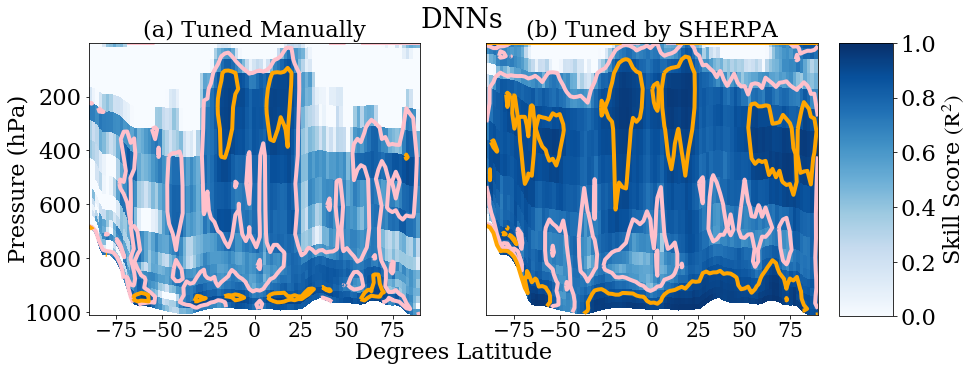

In [58]:
#fig, ax = plt.subplots(1,2, figsize=(15,7))
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].pcolor(SPCAM5_Xs, SPCAM5_pband, No_SHERPA_SPCAM5_heat_15, cmap = 'Blues', vmin = 0, vmax = 1.0)
ax[0].contour(SPCAM5_Xs, SPCAM5_pband, No_SHERPA_SPCAM5_heat_15, [0.7], colors='pink', linewidths=[4])
ax[0].contour(SPCAM5_Xs, SPCAM5_pband, No_SHERPA_SPCAM5_heat_15, [0.9], colors='orange', linewidths=[4])
ax[0].set_title("(a) Tuned Manually", fontsize = fz)
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].set_xlabel("Degrees Latitude")
ax[0].xaxis.set_label_coords(1.1,-0.10)
ax[0].locator_params(nbins=8)
ax[0].tick_params(axis='x', labelsize=fz*0.9)

ax[1].pcolor(SPCAM5_Xs, SPCAM5_pband, SPCAM5_heat_15, cmap = 'Blues', vmin = 0, vmax = 1.0)
ax[1].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_heat_15, [0.7], colors='pink', linewidths=[4])
ax[1].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_heat_15, [0.9], colors='orange', linewidths=[4])
ax[1].set_title("(b) Tuned by SHERPA", fontsize = fz)
ax[1].set_yticks([])
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].set_ylabel("Pressure (hPa)")
ax[1].yaxis.set_label_coords(-1.38,0.5)
ax[1].locator_params(nbins=8)
ax[1].tick_params(axis='x', labelsize=fz*0.9)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.05, 0.76])
fig.colorbar(contour_plot, label="Skill Score "+r'$\left(\mathrm{R^{2}}\right)$', cax=cbar_ax)
plt.suptitle("DNNs", x=0.47)

plt.savefig("Figures/Figure2.png")
plt.savefig("Figures/Figure2.pdf")

# Potential alternative Figure For Mike

In [59]:
def bracket(ax, pos=[0,0], scalex=1, scaley=1, text="",textkw = {}, linekw = {}):
    #x = np.array([0, 0.05, 0.45,0.5])
    x = np.array([0, 5, 4.5,50])
    print(x)
    y = np.array([0,-0.01,-0.01,-0.02])
    print(y)
    x = np.concatenate((x,x+0.5)) 
    y = np.concatenate((y,y[::-1]))
    ax.plot(x*scalex+pos[0], y*scaley+pos[1], clip_on=False, 
            transform=ax.get_xaxis_transform(), **linekw)
    ax.text(pos[0]+0.5*scalex, (y.min()-0.01)*scaley+pos[1], text, 
                transform=ax.get_xaxis_transform(),
                ha="center", va="top", **textkw)
    



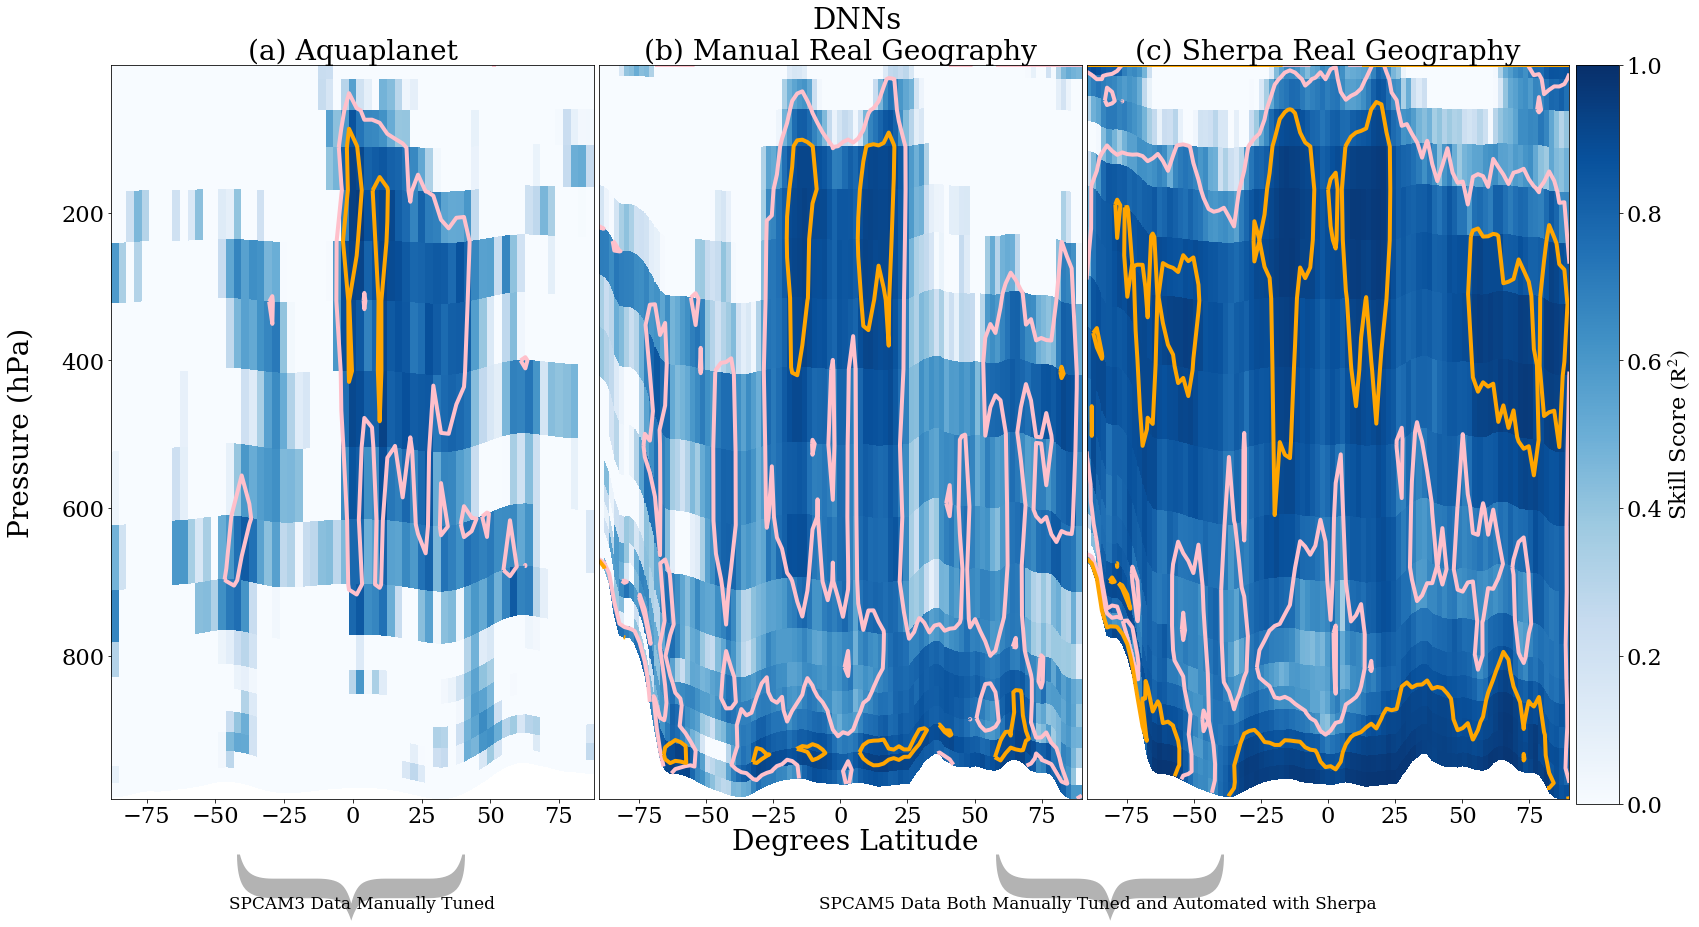

In [60]:
#fig, ax = plt.subplots(1,2, figsize=(15,7))
#fig, ax = plt.subplots(1,3, figsize=(25,8.5))
fig, ax = plt.subplots(1,3, figsize=(30,13.5))

ax[0].pcolor(SPCAM3_Xs, SPCAM3_pband, SPCAM3_heat_15, cmap = 'Blues', vmin = 0, vmax = 1.0)
ax[0].contour(SPCAM3_Xs, SPCAM3_pband, SPCAM3_heat_15, [0.7], colors='pink', linewidths=[4])
ax[0].contour(SPCAM3_Xs, SPCAM3_pband, SPCAM3_heat_15, [0.9], colors='orange', linewidths=[4])
ax[0].set_title("(a) Aquaplanet", fontsize = fz*1.25)
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].set_xlabel("Degrees Latitude", fontsize=fz*1.25)
ax[0].xaxis.set_label_coords(1.54,-0.04)
ax[0].locator_params(nbins=8)
ax[0].tick_params(axis='x', labelsize=fz)

ax[1].pcolor(SPCAM5_Xs, SPCAM5_pband, No_SHERPA_SPCAM5_heat_15, cmap = 'Blues', vmin = 0, vmax = 1.0)
ax[1].contour(SPCAM5_Xs, SPCAM5_pband, No_SHERPA_SPCAM5_heat_15, [0.7], colors='pink', linewidths=[4])
ax[1].contour(SPCAM5_Xs, SPCAM5_pband, No_SHERPA_SPCAM5_heat_15, [0.9], colors='orange', linewidths=[4])
ax[1].set_title("(b) Manual Real Geography", fontsize = fz*1.25)
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].set_yticks([])
#ax[0].set_xlabel("Degrees Latitude")
#ax[0].xaxis.set_label_coords(1.1,-0.10)
ax[1].locator_params(nbins=8)
ax[1].tick_params(axis='x', labelsize=fz)

ax[2].pcolor(SPCAM5_Xs, SPCAM5_pband, SPCAM5_heat_15, cmap = 'Blues', vmin = 0, vmax = 1.0)
ax[2].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_heat_15, [0.7], colors='pink', linewidths=[4])
ax[2].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_heat_15, [0.9], colors='orange', linewidths=[4])
ax[2].set_title("(c) Sherpa Real Geography", fontsize = fz*1.25)
ax[2].set_yticks([])
ax[2].set_ylim(ax[2].get_ylim()[::-1])
ax[2].set_ylabel("Pressure (hPa)", fontsize=fz*1.25)
ax[2].yaxis.set_label_coords(-2.18,0.5)
ax[2].locator_params(nbins=8)
ax[2].tick_params(axis='x', labelsize=fz)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.803, 0.12, 0.02, 0.76])
fig.colorbar(contour_plot, label="Skill Score "+r'$\left(\mathrm{R^{2}}\right)$', cax=cbar_ax)
plt.suptitle("DNNs", x=0.47, y=0.94, fontsize=fz*1.3)
plt.subplots_adjust(wspace=0.01)

trans = ax[0].get_xaxis_transform() # x in data untis, y in axes fraction
ax[0].annotate(r"$\}$", fontsize=265, alpha=0.3, xy=(-45, -0.09), xycoords=trans, rotation=270)
ax[0].annotate("SPCAM3 Data Manually Tuned", fontsize=fz*0.75, xy=(-45, -0.15), xycoords=trans)

trans = ax[1].get_xaxis_transform() # x in data untis, y in axes fraction
ann = ax[1].annotate(r"$\}$", fontsize=265, alpha=0.3, xy=(55, -0.09), xycoords=trans, rotation=270)
ax[1].annotate("SPCAM5 Data Both Manually Tuned and Automated with Sherpa", fontsize=fz*0.75, xy=(-8, -0.15), xycoords=trans)

plt.savefig("Figures/Alt_Figure2.png")
plt.savefig("Figures/Alt_Figure2.pdf")

In [61]:
No_SHERPA_SPCAM5_heat_15[No_SHERPA_SPCAM5_heat_15 < 0.0] = 0.0
No_SHERPA_SPCAM5_heat_15[No_SHERPA_SPCAM5_heat_15 > 1.0] = 1.0
No_SHERPA_SPCAM5_moist_15[No_SHERPA_SPCAM5_moist_15 < 0.0] = 0.0
No_SHERPA_SPCAM5_moist_15[No_SHERPA_SPCAM5_moist_15 > 1.0] = 1.0

print("SPCAM5 Heat Global 25th Percentile is",np.percentile(No_SHERPA_SPCAM5_heat_15,25))
print("SPCAM5 Heat Global 50th Percentile is",np.percentile(No_SHERPA_SPCAM5_heat_15,50))
print("SPCAM5 Heat Global 75th Percentile is",np.percentile(No_SHERPA_SPCAM5_heat_15,75))

print("SPCAM5 Moisture Global 25th Percentile is",np.percentile(No_SHERPA_SPCAM5_moist_15,25))
print("SPCAM5 Moisture Global 50th Percentile is",np.percentile(No_SHERPA_SPCAM5_moist_15,50))
print("SPCAM5 Moisture Global 75th Percentile is",np.percentile(No_SHERPA_SPCAM5_moist_15,75))

SPCAM5 Heat Global 25th Percentile is 0.0
SPCAM5 Heat Global 50th Percentile is 0.3325290785312714
SPCAM5 Heat Global 75th Percentile is 0.7012052401032118
SPCAM5 Moisture Global 25th Percentile is 0.0
SPCAM5 Moisture Global 50th Percentile is 0.0
SPCAM5 Moisture Global 75th Percentile is 0.25645565268407744


In [62]:
others = netCDF4.Dataset("Compressed_Data/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-72000.nc")
lons = np.array(others.variables['lon'])
lats = np.array(others.variables['lat'])
Xvar, Yvar = np.meshgrid(lons, lats)

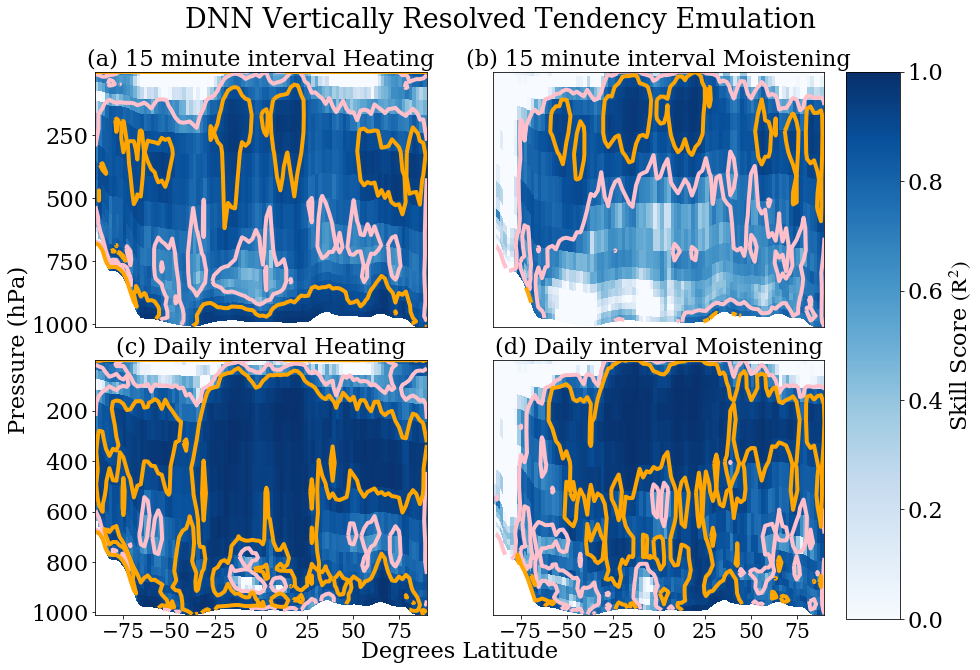

In [63]:
#fig, ax = plt.subplots(2,2, figsize=(15,15))
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].pcolor(SPCAM5_Xs, SPCAM5_pband, SPCAM5_heat_15, cmap = 'Blues', vmin = 0, vmax = 1.0)
ax[0,0].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_heat_15, [0.7], colors='pink', linewidths=[4])
ax[0,0].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_heat_15, [0.9], colors='orange', linewidths=[4])
ax[0,0].set_title("(a) 15 minute interval Heating", fontsize = fz)
ax[0,0].set_ylim(ax[0,0].get_ylim()[::-1])
ax[0,0].set_xticks([])

ax[0,1].pcolor(SPCAM5_Xs, SPCAM5_pband, SPCAM5_moisture_15, cmap = 'Blues', vmin = 0, vmax = 1.0)
ax[0,1].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_moisture_15, [0.7], colors='pink', linewidths=[4])
ax[0,1].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_moisture_15, [0.9], colors='orange', linewidths=[4])
ax[0,1].set_title("(b) 15 minute interval Moistening", fontsize = fz)
ax[0,1].set_ylim(ax[0,1].get_ylim()[::-1])
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_ylabel("Pressure (hPa)")
ax[0,1].yaxis.set_label_coords(-1.40,-0.09)

ax[1,0].pcolor(SPCAM5_Xs, SPCAM5_pband, SPCAM5_heat_Daily, cmap = 'Blues', vmin = 0, vmax = 1.0)
ax[1,0].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_heat_Daily, [0.7], colors='pink', linewidths=[4])
ax[1,0].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_heat_Daily, [0.9], colors='orange', linewidths=[4])
ax[1,0].set_title("(c) Daily interval Heating", fontsize = fz)
ax[1,0].set_ylim(ax[1,0].get_ylim()[::-1])
ax[1,0].locator_params(nbins=8)
ax[1,0].tick_params(axis='x', labelsize=fz*0.9)

contour_plot = ax[1,1].pcolor(SPCAM5_Xs, SPCAM5_pband, SPCAM5_moisture_Daily, cmap = 'Blues', vmin = 0, vmax = 1.0)
ax[1,1].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_moisture_Daily, [0.7], colors='pink', linewidths=[4])
ax[1,1].contour(SPCAM5_Xs, SPCAM5_pband, SPCAM5_moisture_Daily, [0.9], colors='orange', linewidths=[4])
ax[1,1].set_title("(d) Daily interval Moistening", fontsize = fz)
ax[1,1].set_ylim(ax[1,1].get_ylim()[::-1])
ax[1,1].set_yticks([])
ax[1,1].set_xlabel("Degrees Latitude")
ax[1,1].xaxis.set_label_coords(-0.10,-0.10)
ax[1,1].locator_params(nbins=8)
ax[1,1].tick_params(axis='x', labelsize=fz*0.9)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.05, 0.76])
fig.colorbar(contour_plot, label="Skill Score "+r'$\left(\mathrm{R^{2}}\right)$', cax=cbar_ax)
plt.suptitle("DNN Vertically Resolved Tendency Emulation", y=0.97)
plt.subplots_adjust(hspace=0.13)
print(" ")

plt.savefig("Figures/Figure4.png")
plt.savefig("Figures/Figure4.pdf")

In [64]:
SPCAM5_heat_15 = np.load("Compressed_Data/15_Min_Interval_Heat.npy")

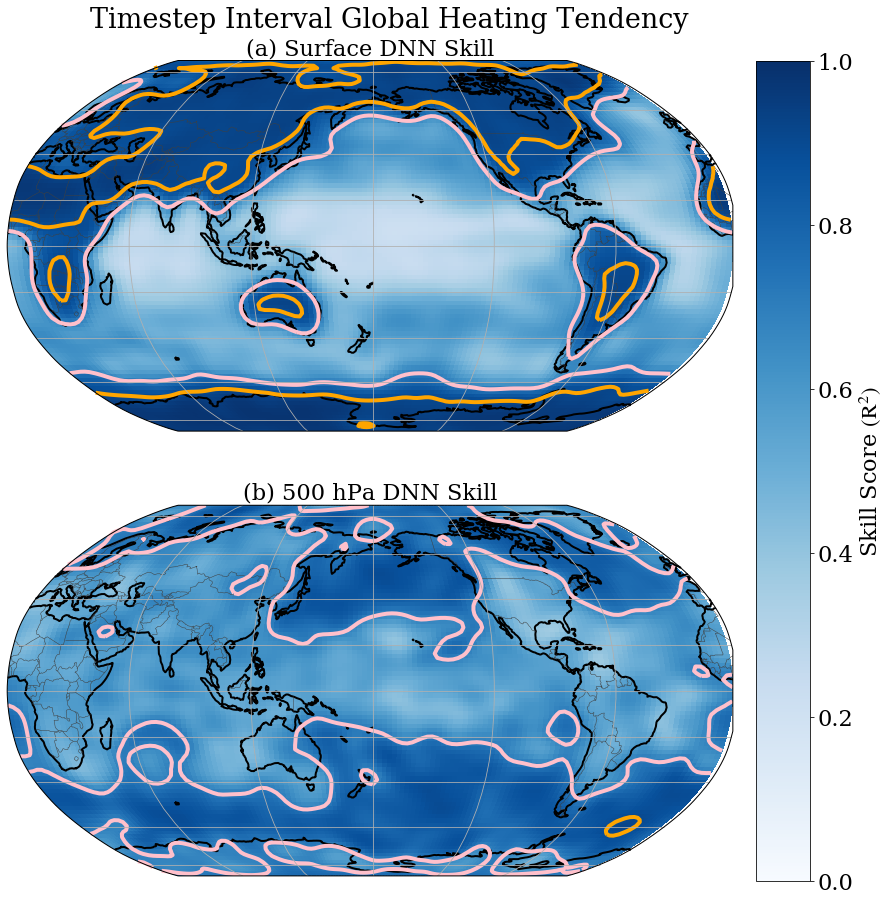

In [65]:
fig, ax = plt.subplots(2,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig.set_size_inches(15,15)

#SPCAM5_lat_lon_new = gaussian_filter(SPCAM5_lat_lon, 2, mode='nearest')
SPCAM5_lat_lon_new = gaussian_filter(np.squeeze(SPCAM5_heat_15[:,:,-1]), 2, mode='nearest')
contour_plot = ax[0].pcolormesh(Xvar, Yvar, SPCAM5_lat_lon_new.T,cmap='Blues', vmin = 0, vmax = 1.0, transform=ccrs.PlateCarree())
ax[0].contour(Xvar, Yvar, SPCAM5_lat_lon_new.T, [0.7], colors='pink', linewidths=[4], transform=ccrs.PlateCarree())
ax[0].contour(Xvar, Yvar, SPCAM5_lat_lon_new.T, [0.9], colors='orange', linewidths=[4], transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.05, 0.76])
fig.colorbar(contour_plot, label="Skill Score "+r'$\left(\mathrm{R^{2}}\right)$', cax=cbar_ax)
#plt.colorbar(contour_plot, label = "Skill Score "+r'$\left(\mathrm{R^{2}}\right)$', ax=ax[0])
ax[0].set_title('(a) Surface DNN Skill', fontsize = fz)
ax[0].coastlines(linewidth=2.0,edgecolor='0.25')
ax[0].gridlines()
ax[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#SPCAM5_500_new = gaussian_filter(SPCAM5_500, 2, mode='nearest')
SPCAM5_500_new = gaussian_filter(np.squeeze(SPCAM5_heat_15[:,:,-12]), 2, mode='nearest')
contour_plot = ax[1].pcolormesh(Xvar, Yvar, SPCAM5_500_new.T,cmap='Blues', vmin = 0, vmax = 1.0, transform=ccrs.PlateCarree())
ax[1].contour(Xvar, Yvar, SPCAM5_500_new.T, [0.7], colors='pink', linewidths=[4], transform=ccrs.PlateCarree())
ax[1].contour(Xvar, Yvar, SPCAM5_500_new.T, [0.9], colors='orange', linewidths=[4], transform=ccrs.PlateCarree())
#plt.colorbar(contour_plot, label = "Skill Score "+r'$\left(\mathrm{R^{2}}\right)$', ax=ax[1])
ax[1].set_title('(b) 500 hPa DNN Skill', fontsize = fz)
ax[1].coastlines(linewidth=2.0,edgecolor='0.25')
ax[1].gridlines()
ax[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.suptitle("Timestep Interval Global Heating Tendency", y=0.93, x=0.48)

plt.savefig("Figures/Figure3.png")
plt.savefig("Figures/Figure3.pdf")

In [66]:
Moisture_Spectra_True = np.load("Compressed_Data/Weighted_Basic_Spectral_Truth_Moistening.npy")
Moisture_Spectra_Predict = np.load("Compressed_Data/Weighted_Basic_Spectral_Prediction_Moistening.npy")
Heat_Spectra_Predict = np.load("Compressed_Data/Weighted_Basic_Spectral_Prediction_Heat.npy")
Heat_Spectra_True = np.load("Compressed_Data/Weighted_Basic_Spectral_Truth_Heat.npy")
SPCAM5_freqs = np.load('Compressed_Data/Basic_Spectral_Frequencies.npy')
CAM_Heat_Spectra = np.load('Compressed_Data/Updated_Weighted_CAM_Spectra_Heat.npy')
CAM_Moisture_Spectra = np.load('Compressed_Data/Updated_Weighted_CAM_Spectra_Moisture.npy')
CAM_Freqs_Spectra = np.load('Compressed_Data/Updated_CAM_Spectra_freqs_Moisture.npy')

Ocean_Moisture_Spectra_True = np.load("Compressed_Data/Weighted_Basic_Spectral_Truth_Moisture_Ocean.npy")
Ocean_Moisture_Spectra_Predict = np.load("Compressed_Data/Weighted_Basic_Spectral_Prediction_Moisture_Ocean.npy")
Ocean_Heat_Spectra_True = np.load("Compressed_Data/Weighted_Basic_Spectral_Truth_Heat_Ocean.npy")
Ocean_Heat_Spectra_Predict = np.load("Compressed_Data/Weighted_Basic_Spectral_Prediction_Heat_Ocean.npy")
Ocean_CAM_Heat_Spectra = np.load('Compressed_Data/Weighted_CAM_Spectra_Heat_Ocean.npy')
Ocean_CAM_Moisture_Spectra = np.load('Compressed_Data/Weighted_CAM_Spectra_Moisture_Ocean.npy')

Land_Moisture_Spectra_True = np.load("Compressed_Data/Weighted_Basic_Spectral_Truth_Moisture_Land.npy")
Land_Moisture_Spectra_Predict = np.load("Compressed_Data/Weighted_Basic_Spectral_Prediction_Moisture_Land.npy")
Land_Heat_Spectra_Predict = np.load("Compressed_Data/Weighted_Basic_Spectral_Prediction_Heat_Land.npy")
Land_Heat_Spectra_True = np.load("Compressed_Data/Weighted_Basic_Spectral_Truth_Heat_Land.npy")
Land_CAM_Heat_Spectra = np.load('Compressed_Data/Weighted_CAM_Spectra_Heat_Land.npy')
Land_CAM_Moisture_Spectra = np.load('Compressed_Data/Weighted_CAM_Spectra_Moisture_Land.npy')

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/export/home/gmooers/miniconda

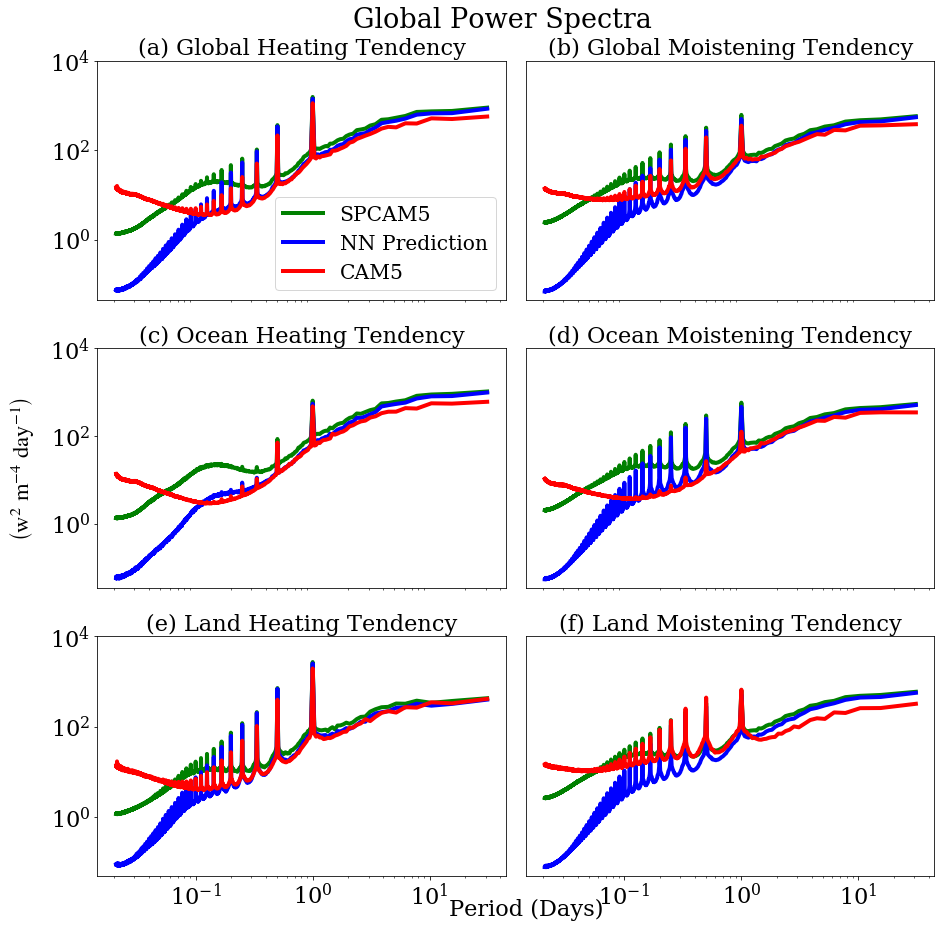

In [67]:
fig, ax = plt.subplots(3,2, figsize=(15,15))

ax[0,0].plot(1/SPCAM5_freqs, Heat_Spectra_True, label = "SPCAM5", color="green")
ax[0,0].plot(1/SPCAM5_freqs, Heat_Spectra_Predict, label = "NN Prediction", color="blue")
ax[0,0].plot(1/CAM_Freqs_Spectra[:-1], CAM_Heat_Spectra[:-1], label = "CAM5", color="red")
ax[0,0].set_title("(a) Global Heating Tendency", fontsize = fz)
ax[2,0].set_xlabel("Period (Days)")
ax[2,0].xaxis.set_label_coords(1.05,-0.095)
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].legend(prop={'size': fz*0.9})
ax[0,0].set_xticks([])
#ax[0,0].set_ylim(1e-11, 1e-5)

ax[0,1].plot(1/SPCAM5_freqs, Moisture_Spectra_True, label = "SPCAM5", color="green")
ax[0,1].plot(1/SPCAM5_freqs, Moisture_Spectra_Predict, label = "NN Prediction", color="blue")
ax[0,1].plot(1/CAM_Freqs_Spectra[:-1], CAM_Moisture_Spectra[:-1], label = "CAM5", color="red")
ax[0,1].set_title("(b) Global Moistening Tendency", fontsize = fz)
ax[1,1].set_ylabel(r'$\left(\mathrm{w^{2} \ m^{-4} \ day^{-1}}\right)$')
ax[0,1].yaxis.set_label_coords(-1.20,0.5)
ax[0,1].set_xscale("log")
ax[0,1].set_yscale("log")
ax[0,1].yaxis.tick_right()
ax[0,1].set_xticks([])
#ax[0,1].set_ylim(1e-17, 1e-12)

ax[1,0].plot(1/SPCAM5_freqs, Ocean_Heat_Spectra_True, color="green")
ax[1,0].plot(1/SPCAM5_freqs, Ocean_Heat_Spectra_Predict, color="blue")
ax[1,0].plot(1/CAM_Freqs_Spectra[:-1], Ocean_CAM_Heat_Spectra[:-1], color="red")
ax[1,0].set_title("(c) Ocean Heating Tendency", fontsize = fz)
#ax[0,0].set_xlabel("Period (Days)")
#ax[0,0].xaxis.set_label_coords(1.05,-0.095)
ax[1,0].set_xscale("log")
ax[1,0].set_yscale("log")
#ax[0,0].legend(prop={'size': fz*0.9})
ax[1,0].set_xticks([])
#ax[1,0].set_ylim(1e-11, 1e-5)

ax[1,1].plot(1/SPCAM5_freqs, Ocean_Moisture_Spectra_True, color="green")
ax[1,1].plot(1/SPCAM5_freqs, Ocean_Moisture_Spectra_Predict, color="blue")
ax[1,1].plot(1/CAM_Freqs_Spectra[:-1], Ocean_CAM_Moisture_Spectra[:-1], color="red")
ax[1,1].set_title("(d) Ocean Moistening Tendency", fontsize = fz)
#ax[0,1].set_ylabel(r'$\left(\mathrm{w^{2} \ m^{-2} \ day^{-1}}\right)$')
ax[1,1].yaxis.set_label_coords(-1.20,0.5)
ax[1,1].set_xscale("log")
ax[1,1].set_yscale("log")
ax[1,1].yaxis.tick_right()
ax[1,1].set_xticks([])
#ax[1,1].set_ylim(1e-17, 1e-12)

ax[2,0].plot(1/SPCAM5_freqs, Land_Heat_Spectra_True, color="green")
ax[2,0].plot(1/SPCAM5_freqs, Land_Heat_Spectra_Predict, color="blue")
ax[2,0].plot(1/CAM_Freqs_Spectra[:-1], Land_CAM_Heat_Spectra[:-1], color="red")
ax[2,0].set_title("(e) Land Heating Tendency", fontsize = fz)
#ax[0,0].set_xlabel("Period (Days)")
#ax[0,0].xaxis.set_label_coords(1.05,-0.095)
ax[2,0].set_xscale("log")
ax[2,0].set_yscale("log")
#ax[0,0].legend(prop={'size': fz*0.9})
#ax[2,0].set_ylim(1e-11, 1e-5)

ax[2,1].plot(1/SPCAM5_freqs, Land_Moisture_Spectra_True, color="green")
ax[2,1].plot(1/SPCAM5_freqs, Land_Moisture_Spectra_Predict, color="blue")
ax[2,1].plot(1/CAM_Freqs_Spectra[:-1], Land_CAM_Moisture_Spectra[:-1], color="red")
ax[2,1].set_title("(f) Land Moistening Tendency", fontsize = fz)
#ax[0,1].set_ylabel(r'$\left(\mathrm{w^{2} \ m^{-2} \ day^{-1}}\right)$')
ax[2,1].yaxis.set_label_coords(-1.20,0.5)
ax[2,1].set_xscale("log")
ax[2,1].set_yscale("log")
ax[2,1].yaxis.tick_right()
#ax[2,1].set_ylim(1e-17, 1e-12)

ymin=0
ymax=1e4
ax[0,0].set_ylim(ymin, ymax)
ax[0,1].set_ylim(ymin, ymax)
ax[1,0].set_ylim(ymin, ymax)
ax[1,1].set_ylim(ymin, ymax)
ax[2,0].set_ylim(ymin, ymax)
ax[2,1].set_ylim(ymin, ymax)

ax[0,1].set_yticks([])
ax[1,1].set_yticks([])
ax[2,1].set_yticks([])

plt.suptitle("Global Power Spectra", y=0.93)
plt.subplots_adjust(wspace=0.05)

plt.savefig("Figures/Figure5.png")
plt.savefig("Figures/Figure5.pdf")

In [93]:
def LSD(sig_1, sig_2):
    LSE = 0
    for i in range(len(sig_1)):
        LSE += (np.log(sig_1[i]/sig_2[i]))**2
    LSE = LSE/len(sig_1)
    LSE= LSE**0.5
    print("Log Spectral Distance is", LSE)
    return LSE

LSD(Heat_Spectra_True, Heat_Spectra_Predict)
#LSD(Heat_Spectra_True, CAM_Heat_Spectra[:-1])

LSD(Moisture_Spectra_True, Moisture_Spectra_Predict)
#LSD(Moisture_Spectra_True, CAM_Moisture_Spectra[:-1])

LSD(Ocean_Heat_Spectra_True, Ocean_Heat_Spectra_Predict)
#LSD(Ocean_Heat_Spectra_True, Ocean_CAM_Heat_Spectra[:-1])

LSD(Ocean_Moisture_Spectra_True, Ocean_Moisture_Spectra_Predict)
#LSD(Ocean_Moisture_Spectra_True, Ocean_CAM_Moisture_Spectra[:-1])

LSD(Land_Heat_Spectra_True, Land_Heat_Spectra_Predict)
#LSD(Land_Heat_Spectra_True, Land_CAM_Heat_Spectra[:-1])

LSD(Land_Moisture_Spectra_True, Land_Moisture_Spectra_Predict)
#LSD(Land_Moisture_Spectra_True, Land_CAM_Moisture_Spectra[:-1])
print(" ")

Log Spectral Distance is 2.395888556623852
Log Spectral Distance is 2.6789473638361634
Log Spectral Distance is 2.596436341997947
Log Spectral Distance is 2.6789473638361634
Log Spectral Distance is 2.101038440138632
Log Spectral Distance is 2.6789473638361634
 


In [68]:
Autocorr_latlon_freq = np.load("Compressed_Data/Autocorr_SFC_Frequency.npy")
April_SPCAM5_lat_lon = np.load("Compressed_Data/April_SPCAM5_15_Min_Interval_Heat.npy")
SPCAM5_lat_lon = April_SPCAM5_lat_lon[:,:,-1]
R2_Bottom_10 = np.percentile(SPCAM5_lat_lon, 10)
Autocorr_Top_10 = np.percentile(Autocorr_latlon_freq, 90)

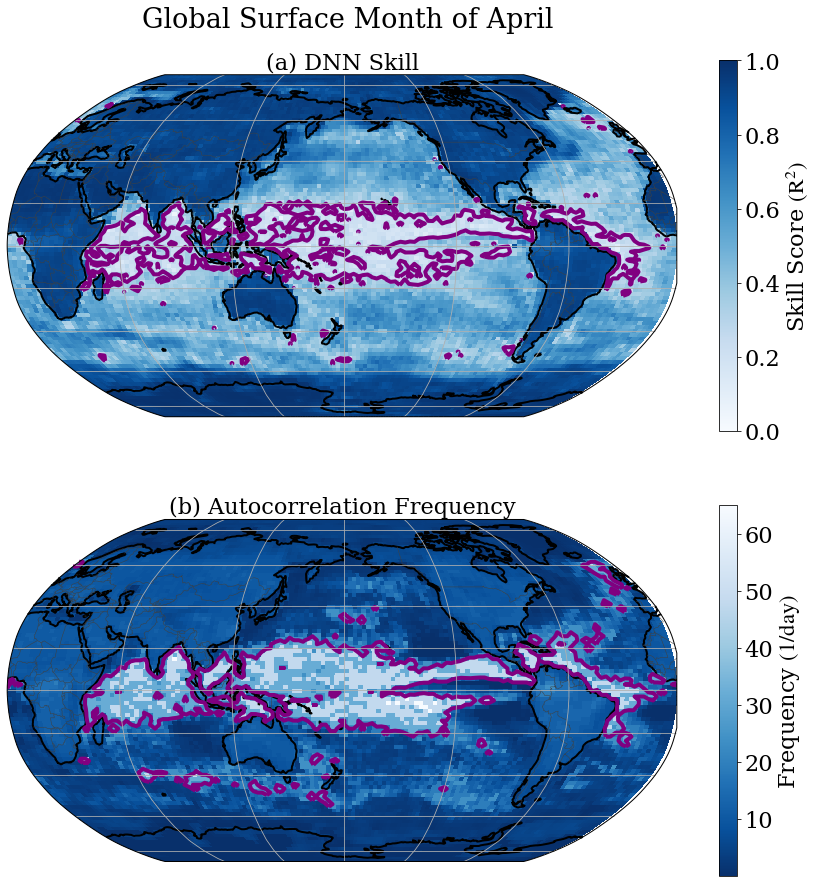

In [69]:
fig, ax = plt.subplots(2,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig.set_size_inches(15,15)
contour_plot = ax[0].pcolormesh(Xvar, Yvar, np.squeeze(SPCAM5_heat_15[:,:,-1].T),cmap='Blues', vmin = 0, vmax = 1.0, transform=ccrs.PlateCarree())
ax[0].contour(Xvar, Yvar, np.squeeze(SPCAM5_heat_15[:,:,-1].T), [R2_Bottom_10], colors='purple', linewidths=[4], transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = "Skill Score "+r'$\left(\mathrm{R^{2}}\right)$', ax=ax[0])
ax[0].set_title('(a) DNN Skill', fontsize = fz)
ax[0].coastlines(linewidth=2.0,edgecolor='0.25')
ax[0].gridlines()
ax[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

contour_plot = ax[1].pcolormesh(Xvar, Yvar, Autocorr_latlon_freq,cmap='Blues_r', vmax = 65, transform=ccrs.PlateCarree())
ax[1].contour(Xvar, Yvar, Autocorr_latlon_freq, [Autocorr_Top_10], colors='purple', linewidths=[4], transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = "Frequency "+r'$\left(\mathrm{1 / day}\right)$', ax=ax[1])
ax[1].set_title('(b) Autocorrelation Frequency', fontsize = fz)
ax[1].coastlines(linewidth=2.0,edgecolor='0.25')
ax[1].gridlines()
ax[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.suptitle("Global Surface Month of April", y=0.93, x=0.44)

plt.savefig("Figures/Figure6.png")
plt.savefig("Figures/Figure6.pdf")

In [70]:
def stats_gen(datas):
    q1 = []
    median = []
    q3 = []
    for i in range(len(datas[0][0])):
        temp = np.squeeze(datas[:,:,i])
        temp = temp.ravel()
        q1.append(np.nanpercentile(temp, 25))
        median.append(np.nanpercentile(temp, 50))
        q3.append(np.nanpercentile(temp, 75))
    
    q1 = np.array(q1)
    median = np.array(median)
    q3 = np.array(q3)
    
    return q1/np.max(median), median/np.max(median), q3/np.max(median)

def Sig_Test(point_b):
    tcoor = np.arange(0, len(point_b), 1)/96
    it = np.argwhere(np.diff(np.sign(point_b/point_b[0]-np.exp(-1))))[0]
    tau = tcoor[it]
    return tau[0]

def e_time_getter(data_array):
    e_times = np.zeros(shape = (x, y))
    e_times[:,:] = np.nan
    for i in range(len(data_array)):
        for j in range(len(data_array[i])):
            temp = np.squeeze(data_array[i,j,:])
            value =  Sig_Test(temp)
            e_times[i,j] = value
            
    e_data = e_times.ravel()
    filtered_data = e_data[~np.isnan(e_data)]
    return filtered_data

In [71]:
Autocorr_Tropical_All = np.load("Compressed_Data/Autocorr_Tropical_All.npy")
Autocorr_Tropical_Good = np.load("Compressed_Data/Autocorr_Tropical_good.npy")
Autocorr_Tropical_Bad = np.load("Compressed_Data/Autocorr_Tropical_bad.npy")
Autocorr_Midlat_All = np.load("Compressed_Data/Autocorr_Midlat_All.npy")
Autocorr_Midlat_Good = np.load("Compressed_Data/Autocorr_Midlat_good.npy")
Autocorr_Midlat_Bad = np.load("Compressed_Data/Autocorr_Midlat_bad.npy")

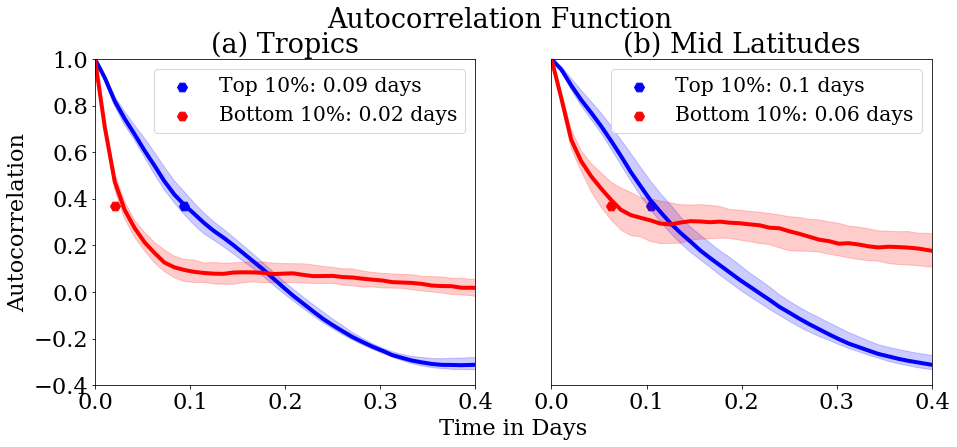

In [72]:
#fig, ax = plt.subplots(1,2,figsize=(15,10))
fig, ax = plt.subplots(1,2,figsize=(15,6))

ax[0].set_title("(a) Tropics")
ax[0].set_xlabel('Time in Days', fontsize = fz)
ax[0].xaxis.set_label_coords(1.1,-0.10)
#good tropics
q1, median, q3 = stats_gen(Autocorr_Tropical_Good)
tcoor = np.arange(0, len(median), 1)/96
y = ax[0].plot(tcoor, median, color = "b")
ax[0].fill_between(tcoor, q1,  q3, alpha = 0.2, color = "b")
it = np.argwhere(np.diff(np.sign(median/median[0]-np.exp(-1))))[0]
tau = tcoor[it]
ax[0].scatter(tau, np.exp(-1)*median[0], s=100, marker = 'H', color = "b", label="Top 10%"+": "+str(round(tau[0],2))+' days')
#bad tropics
q1, median, q3 = stats_gen(Autocorr_Tropical_Bad)
tcoor = np.arange(0, len(median), 1)/96
y = ax[0].plot(tcoor, median, color = "r")
ax[0].fill_between(tcoor, q1,  q3, alpha = 0.2, color = "r")
it = np.argwhere(np.diff(np.sign(median/median[0]-np.exp(-1))))[0]
tau = tcoor[it]
ax[0].scatter(tau, np.exp(-1)*median[0], s=100, marker = 'H', color = "r", label="Bottom 10%"+": "+str(round(tau[0],2))+' days')
ax[0].legend(prop={'size': fz*0.9})
ax[0].set_ylabel("Autocorrelation")
ax[0].set_xlim(0,0.40)
ax[0].set_ylim(-0.4, 1)

ax[1].set_title("(b) Mid Latitudes")
ax[1].set_yticks([])

#good mid lats
q1, median, q3 = stats_gen(Autocorr_Midlat_Good)
tcoor = np.arange(0, len(median), 1)/96
y = ax[1].plot(tcoor, median, color = "b")
ax[1].fill_between(tcoor, q1,  q3, alpha = 0.2, color = "b")
it = np.argwhere(np.diff(np.sign(median/median[0]-np.exp(-1))))[0]
tau = tcoor[it]
ax[1].scatter(tau, np.exp(-1)*median[0], s=100, marker = 'H', color = "b", label="Top 10%"+": "+str(round(tau[0],2))+' days')

#bad midlats
q1, median, q3 = stats_gen(Autocorr_Midlat_Bad)
tcoor = np.arange(0, len(median), 1)/96
y = ax[1].plot(tcoor, median, color = "r")
ax[1].fill_between(tcoor, q1,  q3, alpha = 0.2, color = "r")
it = np.argwhere(np.diff(np.sign(median/median[0]-np.exp(-1))))[0]
tau = tcoor[it]
ax[1].scatter(tau, np.exp(-1)*median[0], s=100, marker = 'H', color = "r", label="Bottom 10%"+": "+str(round(tau[0],2))+' days')

ax[1].legend(prop={'size': fz*0.9})
ax[1].set_xlim(0,0.40) 
ax[1].set_ylim(-0.4, 1)
plt.suptitle("Autocorrelation Function", y=1.0)
plt.savefig("Figures/Figure7.png")
plt.savefig("Figures/Figure7.pdf")

In [73]:
CAM_nan_map_lst = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/LST_PRECIP_CAM.npy")
SPCAM5_nan_map_lst = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/LST_PRECIP_SPCAM5.npy")
SHERPA_nan_map_lst = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/LST_PRECIP_SHERPA.npy")
CONSTRAINED_nan_map_lst = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/LST_PRECIP_CONSTRAINED.npy")
UNCONSTRAINED_nan_map_lst = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/LST_PRECIP_UNCONSTRAINED.npy")

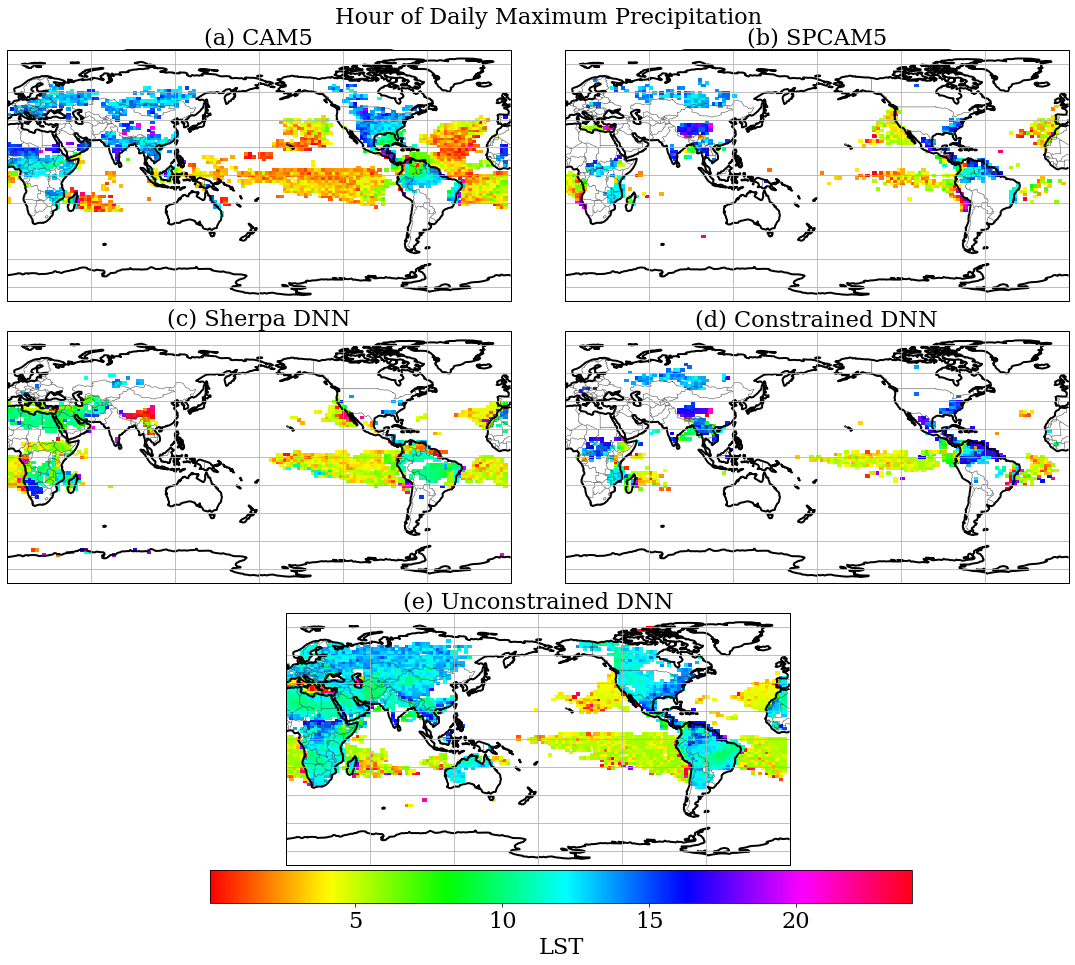

In [74]:
fig, ax = plt.subplots(3,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig.set_size_inches(20,15)

gs=GridSpec(3,2) # 2 rows,  columns

ax1=fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180)) # First row, first column
ax2=fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=180)) # First row, second column 
ax3=fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree(central_longitude=180)) # First row, first column
ax4=fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree(central_longitude=180)) # First row, second column 
ax5=fig.add_subplot(gs[2,:],projection=ccrs.PlateCarree(central_longitude=180)) # Second row, span all columns
ax6=fig.add_subplot(gs[2,1],projection=ccrs.PlateCarree(central_longitude=180))

contour_plot = ax1.pcolormesh(Xvar, Yvar, CAM_nan_map_lst, cmap='hsv', transform=ccrs.PlateCarree())
#plt.colorbar(contour_plot, label = "LST Hour", ax=ax[0])
ax1.set_title('(a) CAM5', fontsize = fz)
ax1.coastlines(linewidth=2.0,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

contour_plot = ax2.pcolormesh(Xvar, Yvar, SPCAM5_nan_map_lst,cmap='hsv', transform=ccrs.PlateCarree())
#plt.colorbar(contour_plot, label = "LST Hour")
ax2.set_title('(b) SPCAM5', fontsize = fz)
ax2.coastlines(linewidth=2.0,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

contour_plot = ax3.pcolormesh(Xvar, Yvar, SHERPA_nan_map_lst,cmap='hsv', transform=ccrs.PlateCarree())
#plt.colorbar(contour_plot, label = "LST Hour", ax=ax[2])
ax3.set_title('(c) Sherpa DNN', fontsize = fz)
ax3.coastlines(linewidth=2.0,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


contour_plot = ax4.pcolormesh(Xvar, Yvar, CONSTRAINED_nan_map_lst,cmap='hsv', transform=ccrs.PlateCarree())
#plt.colorbar(contour_plot, label = "LST Hour", ax=ax[2])
ax4.set_title('(d) Constrained DNN', fontsize = fz)
ax4.coastlines(linewidth=2.0,edgecolor='0.25')
ax4.gridlines()
ax4.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

contour_plot = ax5.pcolormesh(Xvar, Yvar, UNCONSTRAINED_nan_map_lst,cmap='hsv', transform=ccrs.PlateCarree())
#plt.colorbar(contour_plot, label = "LST Hour", ax=ax[2])
ax5.set_title('(e) Unconstrained DNN', fontsize = fz)
ax5.coastlines(linewidth=2.0,edgecolor='0.25')
ax5.gridlines()
ax5.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#ax6.axis('off')
ax6.set_visible(False)
#ax6.clear()
#ax6.remove()
fig.delaxes(ax[2,1])
fig.delaxes(ax[2,0])


p0 = ax1.get_position().get_points().flatten()
p2 = ax1.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0]+0.15, 0.09, p0[1]-0.17, 0.03])
plt.colorbar(contour_plot, cax=ax_cbar, orientation='horizontal', label="LST")
plt.subplots_adjust(hspace=0.12, wspace=0)
plt.suptitle("Hour of Daily Maximum Precipitation", y=0.92, x=0.52, fontsize = fz)
plt.savefig("Figures/Figure8.png")
plt.savefig("Figures/Figure8.pdf")

In [75]:
CON = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Constrained_DNN_Precip_Prediction.npy")
UCON = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Unconstrained_DNN_Precip_Prediction.npy")
D = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_SHERPA_DNN_Precip_Prediction.npy")
T = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_SPCAM5_Prepip_Truth.npy")
C = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_CAM5_PRECIP.npy")
m = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Precip_Max_Scalar.npy")
M = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Precip_Min_Scalar.npy")

CON_ocean = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Constrained_Ocean_SPCAM5_Precip_Prediction.npy")
UCON_ocean = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Unconstrained_Ocean_SPCAM5_Precip_Prediction.npy")
D_ocean = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_SHERPA_Ocean_SPCAM5_Precip_Prediction.npy")
T_ocean = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Ocean_SPCAM5_Prepip_Truth.npy")
C_ocean = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Ocean_CAM5_PRECIP.npy")
m_ocean = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Ocean_Precip_Max_Scalar.npy")
M_ocean = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Ocean_Precip_Min_Scalar.npy")

CON_land = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Constrained_Land_SPCAM5_Precip_Prediction.npy")
UCON_land = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Unconstrained_Land_SPCAM5_Precip_Prediction.npy")
D_land = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_SHERPA_Land_SPCAM5_Precip_Prediction.npy")
T_land = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Land_SPCAM5_Prepip_Truth.npy")
C_land = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Land_CAM5_PRECIP.npy")
m_land = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Land_Precip_Max_Scalar.npy")
M_land = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Summer_Land_Precip_Min_Scalar.npy")


In [76]:
def array_generator(min_val, max_val, percentage):
    listing = []
    for i in range(300):
        if i == 0:
            temp_val = min_val
            listing.append(temp_val)
        else:
            if temp_val < max_val:
                temp_val = temp_val*percentage
                listing.append(temp_val)
        
    return np.array(listing)
#array_generator(0.03, maxi, 1.07)

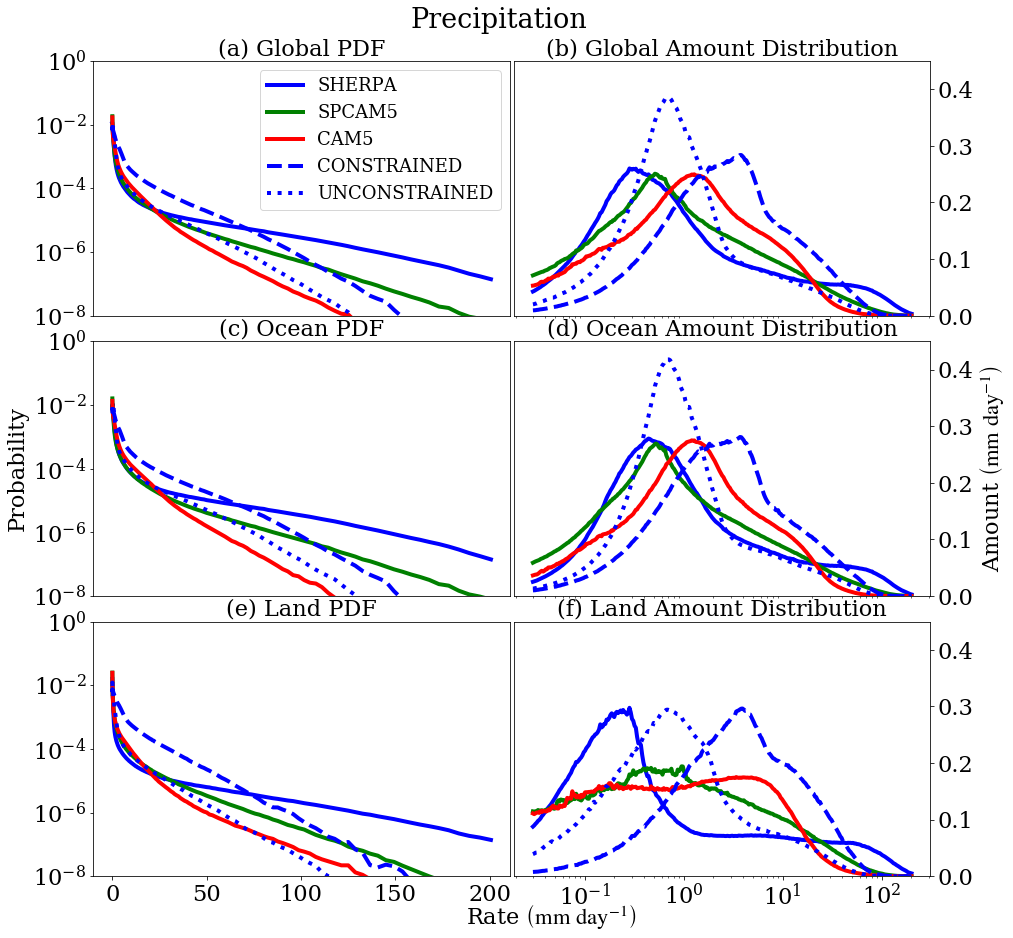

In [77]:
bins = array_generator(0.03, M, 1.03)

fig, ax = plt.subplots(3,2,figsize=(15,15))

shared_bins = np.histogram_bin_edges(D, bins=bins, range=(0, M))
freq, edges = np.histogram(D, bins = shared_bins, density=True)
#bad_freq, bad_edges = np.histogram(bad_feat, bins = shared_bins, density=True)
freq_targ, edges_targ = np.histogram(T, bins = shared_bins, density=True)
freq_cams, edges_cams = np.histogram(C, bins = shared_bins, density=True)
freq_CON, edges_CON = np.histogram(CON, bins = shared_bins, density=True)
freq_UCON, edges_UCON = np.histogram(UCON, bins = shared_bins, density=True)

ax[0,1].set_xscale("log")
ax[1,1].set_xscale("log")
ax[2,1].set_xscale("log")

ax[0,0].plot(edges[:-1], freq/np.sum(freq),  label = "SHERPA", color = 'blue')
ax[0,0].plot(edges_targ[:-1], freq_targ/np.sum(freq_targ), label = "SPCAM5", color = 'green')
ax[0,0].plot(edges_cams[:-1], freq_cams/np.sum(freq_cams), label = "CAM5", color = 'red')
ax[0,0].plot(edges_CON[:-1], freq_CON/np.sum(freq_CON), label = "CONSTRAINED", color = 'blue', linestyle='--')
ax[0,0].plot(edges_UCON[:-1], freq_UCON/np.sum(freq_UCON), label = "UNCONSTRAINED", color = 'blue', linestyle=':')
ax[0,0].set_ylim(1e-8, 1)

ax[2,0].set_xlabel('Rate '+r'$\left(\mathrm{mm \ day^{-1}}\right)$', fontsize = fz)
ax[2,0].xaxis.set_label_coords(1.1,-0.1)
ax[1,0].set_ylabel('Probability', fontsize = fz)
ax[0,0].set_title('(a) Global PDF', fontsize = fz)
ax[1,0].set_title('(c) Ocean PDF', fontsize = fz)
ax[2,0].set_title('(e) Land PDF', fontsize = fz)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks([])
    
totals = freq*edges[:-1]
totals_targ = freq_targ*edges_targ[:-1]
totals_cam = freq_cams*edges_cams[:-1]
totals_CON = freq_CON*edges_CON[:-1]
totals_UCON = freq_UCON*edges_UCON[:-1]
    
ax[0,1].plot(edges[:-1], totals,  label = "SHERPA", color = 'blue')
ax[0,1].plot(edges_targ[:-1], totals_targ, label = "SPCAM5", color = 'green')
ax[0,1].plot(edges_cams[:-1], totals_cam, label = "CAM5", color = 'red')
ax[0,1].plot(edges_CON[:-1], totals_CON, label = "CONSTRAINED", color = 'blue', linestyle='--')
ax[0,1].plot(edges_UCON[:-1], totals_UCON, label = "UNCONSTRAINED", color = 'blue', linestyle=':')



ax[1,1].set_ylabel('Amount '+r'$\left(\mathrm{mm \ day^{-1}}\right)$', fontsize = fz)
ax[0,1].set_title('(b) Global Amount Distribution', fontsize = fz)
ax[1,1].set_title('(d) Ocean Amount Distribution', fontsize = fz)
ax[2,1].set_title('(f) Land Amount Distribution', fontsize = fz)
ax[0,0].legend(fontsize=fz*0.8, loc = 'best')

ax[0,1].yaxis.set_label_position("right")
ax[0,1].yaxis.tick_right()
ax[0,1].set_xticks([])
ax[0,1].set_ylim(0, 0.45)

shared_bins = np.histogram_bin_edges(D_ocean, bins=bins, range=(0, M))
freq, edges = np.histogram(D_ocean, bins = shared_bins, density=True)
freq_targ, edges_targ = np.histogram(T_ocean, bins = shared_bins, density=True)
freq_cams, edges_cams = np.histogram(C_ocean, bins = shared_bins, density=True)
freq_CON, edges_CON = np.histogram(CON_ocean, bins = shared_bins, density=True)
freq_UCON, edges_UCON = np.histogram(UCON_ocean, bins = shared_bins, density=True)

ax[1,0].plot(edges[:-1], freq/np.sum(freq), color = 'blue')
ax[1,0].plot(edges_targ[:-1], freq_targ/np.sum(freq_targ), color = 'green')
ax[1,0].plot(edges_cams[:-1], freq_cams/np.sum(freq_cams),  color = 'red')
ax[1,0].plot(edges_CON[:-1], freq_CON/np.sum(freq_CON), color = 'b', linestyle='--')
ax[1,0].plot(edges_UCON[:-1], freq_UCON/np.sum(freq_UCON),  color = 'b', linestyle=':')
ax[1,0].set_xticks([])
ax[1,0].set_yscale('log')
ax[1,0].set_ylim(1e-8, 1)

totals = freq*edges[:-1]
totals_targ = freq_targ*edges_targ[:-1]
totals_cam = freq_cams*edges_cams[:-1]
totals_CON = freq_CON*edges_CON[:-1]
totals_UCON = freq_UCON*edges_UCON[:-1]

ax[1,1].plot(edges[:-1], totals, color = 'blue')
ax[1,1].plot(edges_targ[:-1], totals_targ, color = 'green')
ax[1,1].plot(edges_cams[:-1], totals_cam, color = 'red')
ax[1,1].plot(edges_CON[:-1], totals_CON, color = 'blue', linestyle='--')
ax[1,1].plot(edges_UCON[:-1], totals_UCON, color = 'blue', linestyle=':')
ax[1,1].set_xticks([])
ax[1,1].yaxis.set_label_position("right")
ax[1,1].yaxis.tick_right()
ax[1,1].set_ylim(0, 0.45)

shared_bins = np.histogram_bin_edges(D_land, bins=bins, range=(0, M))
freq, edges = np.histogram(D_land, bins = shared_bins, density=True)
freq_targ, edges_targ = np.histogram(T_land, bins = shared_bins, density=True)
freq_cams, edges_cams = np.histogram(C_land, bins = shared_bins, density=True)
freq_CON, edges_CON = np.histogram(CON_land, bins = shared_bins, density=True)
freq_UCON, edges_UCON = np.histogram(UCON_land, bins = shared_bins, density=True)

ax[2,0].plot(edges[:-1], freq/np.sum(freq), color = 'blue')
ax[2,0].plot(edges_targ[:-1], freq_targ/np.sum(freq_targ), color = 'green')
ax[2,0].plot(edges_cams[:-1], freq_cams/np.sum(freq_cams),  color = 'red')
ax[2,0].plot(edges_CON[:-1], freq_CON/np.sum(freq_CON), color = 'blue', linestyle='--')
ax[2,0].plot(edges_UCON[:-1], freq_UCON/np.sum(freq_UCON),  color = 'blue', linestyle=':')
ax[2,0].set_yscale('log')
ax[2,0].set_ylim(1e-8, 1)

totals = freq*edges[:-1]
totals_targ = freq_targ*edges_targ[:-1]
totals_cam = freq_cams*edges_cams[:-1]
totals_CON = freq_CON*edges_CON[:-1]
totals_UCON = freq_UCON*edges_UCON[:-1]

ax[2,1].plot(edges[:-1], totals, color = 'blue')
ax[2,1].plot(edges_targ[:-1], totals_targ, color = 'green')
ax[2,1].plot(edges_cams[:-1], totals_cam, color = 'red')
ax[2,1].plot(edges_CON[:-1], totals_CON, color = 'blue', linestyle='--')
ax[2,1].plot(edges_UCON[:-1], totals_UCON, color = 'blue', linestyle=':')
ax[2,1].yaxis.set_label_position("right")
ax[2,1].yaxis.tick_right()
ax[2,1].set_ylim(0, 0.45)
plt.suptitle("Precipitation", y=0.93)
plt.subplots_adjust(wspace=0.01, hspace=0.10)

plt.savefig("Figures/Figure9.png")
plt.savefig("Figures/Figure9.pdf")

In [78]:
jordan_data = pd.read_csv('Compressed_Data/results.csv', sep = ',')

In [79]:
def get_results(version=''):
    #result_dir = 'SherpaResults/land_data_random{}/normal_mse/'.format(version)
    result_dir = '/fast/gmooers/RG_Paper_Data/Jordan_Ott/'

    history_dir = result_dir + 'Models/'
    result_file = result_dir + 'results{}.csv'.format(version)

    df = pd.read_csv(result_file)

    df = df[df['Status'] != 'COMPLETED'].reset_index()

    bad_trials = df[(df['val_loss'] > 0.005) | (df['loss'] > 0.005)]['Trial-ID'].unique()
    df = df[~df['Trial-ID'].isin(bad_trials)].reset_index()
    return df

def combine_dfs(first='',second='2'):
    df1 = get_results(first)
    df2 = get_results(second)
    
    if df1['val_loss'].min() > df2['val_loss'].min():
        print ('Best loss:', df2['val_loss'].min(),'from run 2, trial:', df2.iloc[df2['val_loss'].idxmin()]['Trial-ID'])
    else:
        print ('Best loss:', df1['val_loss'].min(),'from run 1, trial:', df1.iloc[df1['val_loss'].idxmin()]['Trial-ID'])
        
    df2['Trial-ID'] = df1['Trial-ID'].max() + df2['Trial-ID']
    
    print (df2['Trial-ID'].max(), 'models tried...')
    df = df1.append(df2, ignore_index=True)

    return df

In [80]:
baseline = {'val_loss': [0.0027699412128464975, 0.0027675854094271883, 0.002750806139965779, 0.0027184670896490343, 0.002697938473128253, 0.0027200228956737404, 0.002697579861752714, 0.0027041057355993194, 0.0027361180229907287, 0.0027223027184516144, 0.0027174908288899085, 0.002705075166346688, 0.0026945003744093007, 0.002688072946386839, 0.002714479107119437, 0.0027216500134899803, 0.002692673348817968, 0.0027151860584786465, 0.002717053027243123, 0.002696788561289504, 0.0027047853027976796, 0.0027102316666424995, 0.002679989631039186, 0.002674067506729597, 0.0026703028731369], 'loss': [0.0029240883347595847, 0.0027942983982693985, 0.002765629174030718, 0.0027506531794350467, 0.00273707072116032, 0.002728933417163408, 0.0027222536753665214, 0.0027198918636816075, 0.0027193166255475736, 0.0027167066369639882, 0.0027142092041242604, 0.0027110217051854353, 0.0027093022819072265, 0.002706057847611977, 0.0027044928225834425, 0.0027045464933883557, 0.002703787513724742, 0.0027013152791427967, 0.002699959184807386, 0.0026990613309396693, 0.0026981373776758678, 0.0026971993964014012, 0.002695570826957943, 0.002693741966372858, 0.0026922912526016704], 'Iteration':range(25)}
baseline = pd.DataFrame(baseline)

df = combine_dfs()
best_trial = df.iloc[df['val_loss'].idxmin()]['Trial-ID']
best_df = df[df['Trial-ID'] == best_trial]

Best loss: 0.002393034852266267 from run 2, trial: 22
218 models tried...


In [81]:
second_df = combine_dfs('3','4')
best_second_trial = second_df.iloc[second_df['val_loss'].idxmin()]['Trial-ID']
best_second_df = second_df[second_df['Trial-ID'] == best_second_trial]

Best loss: 0.00232526399379592 from run 2, trial: 4
46 models tried...


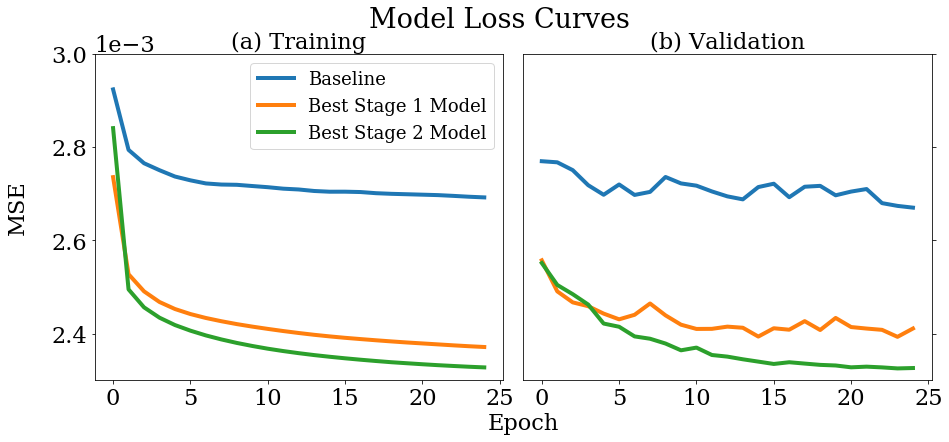

In [82]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].plot(np.arange(0, len(baseline["loss"]), 1), baseline["loss"], label = "Baseline")
ax[0].plot(np.arange(0, len(best_df["loss"]), 1), best_df["loss"], label = "Best Stage 1 Model")
ax[0].plot(np.arange(0, len(best_second_df["loss"]), 1), best_second_df["loss"], label = "Best Stage 2 Model")

ax[0].set_title("(a) Training", fontsize = fz)
ax[0].set_ylabel("MSE")
ax[0].yaxis.set_label_coords(-0.16,0.53)
ax[0].set_xlabel("Epoch")
ax[0].xaxis.set_label_coords(1.05,-0.10)
#ax[0].set_yscale("log")
ax[0].legend(prop={'size': fz*0.8})
ax[0].set_ylim(2.3e-3, 3.0e-3)
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax[1].plot(np.arange(0, len(baseline["val_loss"]), 1), baseline["val_loss"], label = "Baseline")
ax[1].plot(np.arange(0, len(best_df["val_loss"]), 1), best_df["val_loss"], label = "Best Stage 1 Model")
ax[1].plot(np.arange(0, len(best_second_df["val_loss"]), 1), best_second_df["val_loss"], label = "Best Stage 2 Model")

ax[1].set_title("(b) Validation", fontsize = fz)
#ax[1].set_yscale("log")

ax[1].yaxis.set_major_formatter(NullFormatter())
ax[1].yaxis.set_minor_formatter(NullFormatter())
ax[1].yaxis.tick_right()
ax[1].set_ylim(2.3e-3, 3.0e-3)
#ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.suptitle("Model Loss Curves", y=0.99)
plt.subplots_adjust(wspace=0.05)

#plt.savefig("Figures/Figure11.png")
#plt.savefig("Figures/Figure11.pdf")

In [83]:
SSE_SHERPA_SPCAM5_heat_daily = np.load("Compressed_Data/SSE_Daily_Interval_Heat.npy")
SSE_SHERPA_SPCAM5_moisture_daily = np.load("Compressed_Data/SSE_Daily_Interval_Moisture.npy")

SVAR_SHERPA_SPCAM5_heat_daily = np.load("Compressed_Data/SVAR_Daily_Interval_Heat.npy")
SVAR_SHERPA_SPCAM5_moisture_daily = np.load("Compressed_Data/SVAR_Daily_Interval_Moisture.npy")

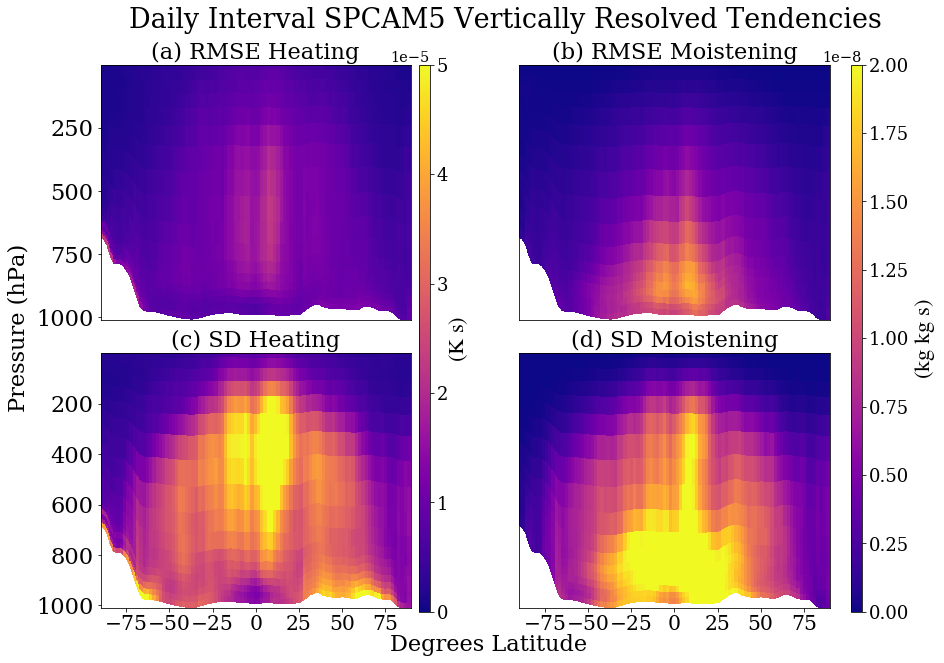

In [84]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

cp = ax[0,0].pcolor(SPCAM5_Xs, SPCAM5_pband, np.nanmean((SSE_SHERPA_SPCAM5_heat_daily/31.0)**0.5, axis = 0), cmap = 'plasma', vmin=0, vmax=0.5e-4)
ax[0,0].set_title("(a) RMSE Heating", fontsize = fz)
ax[0,0].set_ylim(ax[0,0].get_ylim()[::-1])
ax[0,0].set_xticks([])

cp = ax[0,1].pcolor(SPCAM5_Xs, SPCAM5_pband, np.nanmean((SSE_SHERPA_SPCAM5_moisture_daily/31.0)**0.5, axis = 0), cmap = 'plasma', vmin=0, vmax=0.2e-7)
ax[0,1].set_title("(b) RMSE Moistening", fontsize = fz)
ax[0,1].set_ylim(ax[0,1].get_ylim()[::-1])
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_ylabel("Pressure (hPa)")
ax[0,1].yaxis.set_label_coords(-1.58,-0.03)

cp = ax[1,0].pcolor(SPCAM5_Xs, SPCAM5_pband, np.nanmean((SVAR_SHERPA_SPCAM5_heat_daily/(31.0-1.0))**0.5, axis=0), cmap = 'plasma', vmin=0, vmax=0.5e-4)
ax[1,0].set_title("(c) SD Heating", fontsize = fz)
ax[1,0].set_ylim(ax[1,0].get_ylim()[::-1])
#ax[1,0].set_xticks([])
ax[1,0].locator_params(nbins=8)
ax[1,0].tick_params(axis='x', labelsize=fz*0.9)

cbar_ax = fig.add_axes([0.42, 0.12, 0.01, 0.76])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label=r'$\left(\mathrm{K} \ \mathrm{s}\right)$', labelpad=-1.5)
cbar.ax.tick_params(labelsize=fz*0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)

cp = ax[1,1].pcolor(SPCAM5_Xs, SPCAM5_pband, np.nanmean((SVAR_SHERPA_SPCAM5_moisture_daily/(31.0-1.0))**0.5, axis=0), cmap = 'plasma', vmin=0, vmax=0.2e-7)
ax[1,1].set_title("(d) SD Moistening", fontsize = fz)
ax[1,1].set_ylim(ax[1,1].get_ylim()[::-1])
ax[1,1].set_yticks([])
#ax[1,1].set_xticks([])
ax[1,1].set_xlabel("Degrees Latitude")
ax[1,1].xaxis.set_label_coords(-0.10,-0.1)
ax[1,1].locator_params(nbins=8)
ax[1,1].tick_params(axis='x', labelsize=fz*0.9)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.01, 0.76])
cbar = fig.colorbar(cp, label=r'$\left(\mathrm{kg} \ \mathrm{kg} \ \mathrm{s}\right)$', cax=cbar_ax)
cbar.ax.tick_params(labelsize=fz*0.8) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)
#register_bottom_offset(cbar.ax.yaxis, bottom_offset)

plt.suptitle("Daily Interval SPCAM5 Vertically Resolved Tendencies", y = 0.96)
plt.subplots_adjust(hspace=0.13, wspace=0.35)
print(" ")

#plt.savefig("Figures/Figure12.png")
#plt.savefig("Figures/Figure12.pdf")

In [85]:
sd_heat_diff = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/sd_heat_diff.npy")
sd_moist_diff = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/sd_moist_diff.npy")
sd_truth_moist_avg = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/sd_truth_moist_avg.npy")
sd_DNN_moist_avg = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/sd_DNN_moist_avg.npy")
sd_truth_heat_avg = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/sd_truth_heat_avg.npy")
sd_DNN_heat_avg = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/sd_DNN_heat_avg.npy")

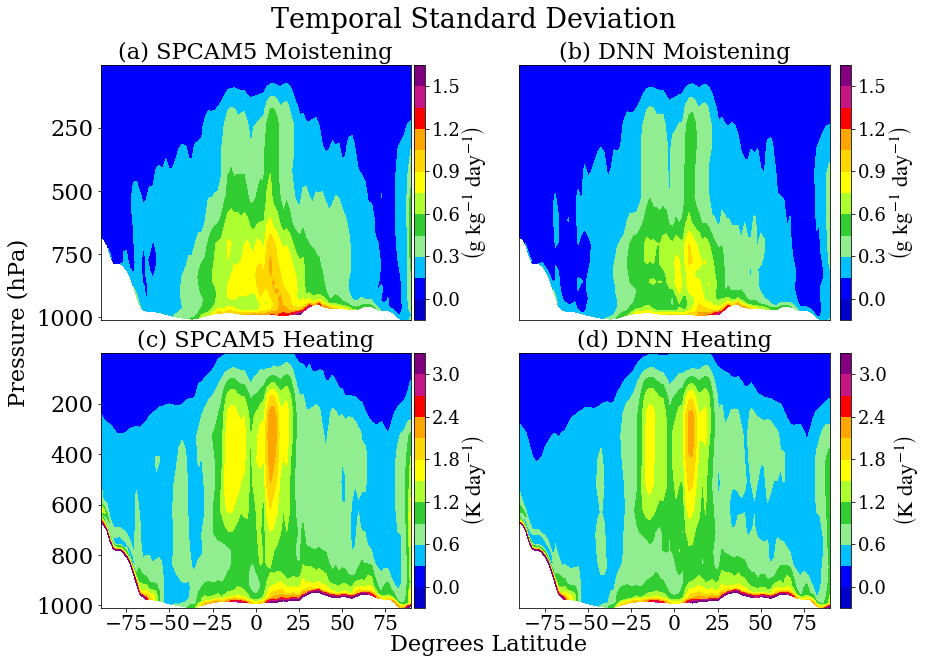

In [86]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
cmap = matplotlib.colors.ListedColormap(["mediumblue","blue", "deepskyblue", "aquamarine", "lightgreen","limegreen","greenyellow","yellow","gold","orange","orangered","red","mediumvioletred","purple"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N) 

cp = ax[0,0].contourf(SPCAM5_Xs, SPCAM5_pband, sd_truth_moist_avg, sd_moist_diff, cmap = cmap, vmin=-0.15, vmax=1.65)
ax[0,0].set_title("(a) SPCAM5 Moistening", fontsize = fz)
ax[0,0].set_ylim(ax[0,0].get_ylim()[::-1])
ax[0,0].set_xticks([])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.415, 0.525, 0.01, 0.355])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label=r'$\left(\mathrm{g} \ \mathrm{kg^{-1}} \ \mathrm{day^{-1}}\right)$', labelpad=-1.5)
cbar.ax.tick_params(labelsize=fz*0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)

cp = ax[0,1].contourf(SPCAM5_Xs, SPCAM5_pband, sd_DNN_moist_avg, sd_moist_diff, cmap = cmap, vmin=-0.15, vmax=1.65)
ax[0,1].set_title("(b) DNN Moistening", fontsize = fz)
ax[0,1].set_ylim(ax[0,1].get_ylim()[::-1])
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_ylabel("Pressure (hPa)")
ax[0,1].yaxis.set_label_coords(-1.58,-0.01)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.525, 0.01, 0.355])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label=r'$\left(\mathrm{g} \ \mathrm{kg^{-1}} \ \mathrm{day^{-1}}\right)$', labelpad=-1.5)
cbar.ax.tick_params(labelsize=fz*0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)

cp = ax[1,0].contourf(SPCAM5_Xs, SPCAM5_pband, sd_truth_heat_avg, sd_heat_diff, cmap = cmap, vmin=-0.3, vmax=3.3)
ax[1,0].set_title("(c) SPCAM5 Heating", fontsize = fz)
ax[1,0].set_ylim(ax[1,0].get_ylim()[::-1])
#ax[1,0].set_xticks([])
ax[1,0].locator_params(nbins=8)
ax[1,0].tick_params(axis='x', labelsize=fz*0.9)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.415, 0.125, 0.01, 0.355])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label=r'$\left(\mathrm{K} \ \mathrm{day^{-1}}\right)$', labelpad=-1.5)
cbar.ax.tick_params(labelsize=fz*0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)

cp = ax[1,1].contourf(SPCAM5_Xs, SPCAM5_pband, sd_DNN_heat_avg, sd_heat_diff, cmap = cmap, vmin=-0.3, vmax=3.3)
ax[1,1].set_title("(d) DNN Heating", fontsize = fz)
ax[1,1].set_ylim(ax[1,1].get_ylim()[::-1])
ax[1,1].set_yticks([])
#ax[1,1].set_xticks([])
ax[1,1].set_xlabel("Degrees Latitude")
ax[1,1].xaxis.set_label_coords(-0.10,-0.1)
ax[1,1].locator_params(nbins=8)
ax[1,1].tick_params(axis='x', labelsize=fz*0.9)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.125, 0.01, 0.355])
cbar = fig.colorbar(cp, label=r'$\left(\mathrm{K} \ \mathrm{day^{-1}}\right)$', cax=cbar_ax)
cbar.ax.tick_params(labelsize=fz*0.8) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)
#register_bottom_offset(cbar.ax.yaxis, bottom_offset)


plt.suptitle("Temporal Standard Deviation", y = 0.96, x=0.47)
plt.subplots_adjust(hspace=0.13, wspace=0.35)
print(" ")

plt.savefig("Figures/Figure11.png")
plt.savefig("Figures/Figure11.pdf")

In [87]:
heat_diff_levels = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/heat_diff_levels.npy")
moist_diff_levels = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/moist_diff_levels.npy")
diff_levels = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/diff_levels.npy")
diff_heat_avg = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/diff_heat_avg.npy")
diff_moist_avg = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/diff_moist_avg.npy")
#diff = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/diff.npy")
diff = np.load("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Annual_Precip_Error.npy")

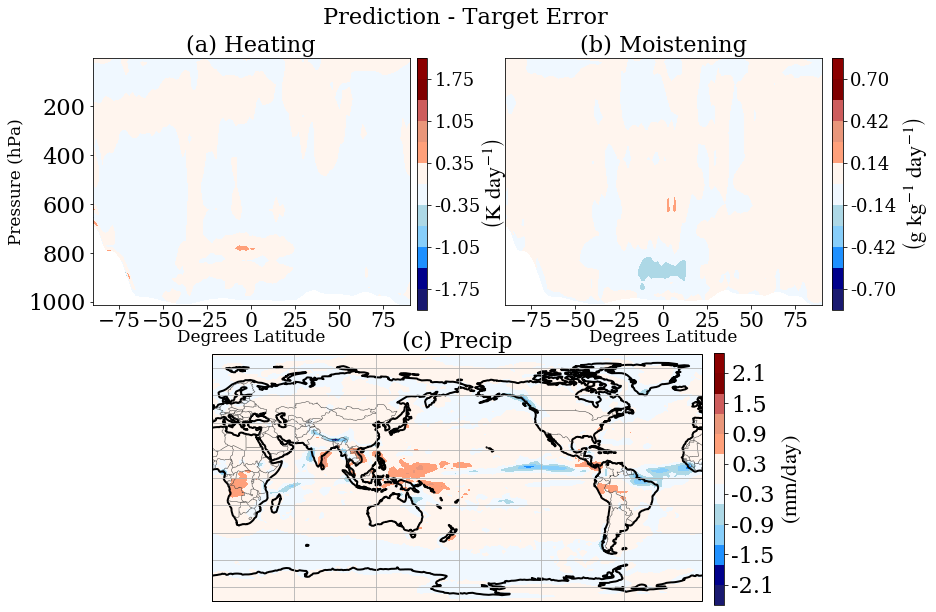

In [88]:
fig=plt.figure(figsize=(15,10))
gs=GridSpec(2,2) # 2 rows,  columns

ax1=fig.add_subplot(gs[0,0]) # First row, first column
ax2=fig.add_subplot(gs[0,1]) # First row, second column 
ax3=fig.add_subplot(gs[1,:],projection=ccrs.PlateCarree(central_longitude=180)) # Second row, span all columns

cmap = matplotlib.colors.ListedColormap(["midnightblue","darkblue","dodgerblue","lightskyblue","lightblue","aliceblue","seashell","lightsalmon","darksalmon","indianred","maroon","darkred"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N)

cp = ax1.contourf(SPCAM5_Xs, SPCAM5_pband, diff_heat_avg, heat_diff_levels, cmap = cmap, vmin=-2.10, vmax=2.10)
ax1.set_title("(a) Heating", fontsize = fz)
#ax1.grid(True)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel("Pressure (hPa)", size=fz*0.75)
ax1.locator_params(nbins=8)
ax1.tick_params(axis='x', labelsize=fz*0.9)
ax1.set_xlabel("Degrees Latitude", fontsize=fz*0.75)
ax1.xaxis.set_label_coords(0.50,-0.1)

cbar_ax = fig.add_axes([0.425, 0.53, 0.01, 0.35])
cbar = fig.colorbar(cp, cax=cbar_ax, ticks=[-1.75,-1.05,-0.35,0.35,1.05,1.75])
cbar.ax.set_yticklabels(['-1.75', '-1.05', '-0.35','0.35','1.05','1.75'])
cbar.set_label(label=r'$\left(\mathrm{K} \ \mathrm{day^{-1}}\right)$', labelpad=-1.5)
cbar.ax.tick_params(labelsize=fz*0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)

cp = ax2.contourf(SPCAM5_Xs, SPCAM5_pband, diff_moist_avg, moist_diff_levels, cmap = cmap, vmin=-0.84, vmax=0.84)
ax2.set_title("(b) Moistening", fontsize = fz)
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_yticks([])
#ax2.grid(True, axis='both')
ax2.set_xlabel("Degrees Latitude", fontsize=fz*0.75)
ax2.xaxis.set_label_coords(0.50,-0.1)
ax2.locator_params(nbins=8)
ax2.tick_params(axis='x', labelsize=fz*0.9)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.53, 0.01, 0.35])
cbar = fig.colorbar(cp, label=r'$\left(\mathrm{g} \ \mathrm{kg^{-1}} \ \mathrm{day^{-1}}\right)$', cax=cbar_ax, ticks=[-0.7,-0.42,-0.14,0.14,0.42,0.70])
cbar.ax.set_yticklabels(['-0.70', '-0.42', '-0.14','0.14','0.42','0.70'])
cbar.ax.tick_params(labelsize=fz*0.8) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)
register_bottom_offset(cbar.ax.yaxis, bottom_offset)

cmap = matplotlib.colors.ListedColormap(["mediumblue","blue", "deepskyblue", "aquamarine", "lightgreen","limegreen","greenyellow","yellow","gold","orange","orangered","red","mediumvioletred","purple"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N) 

cmap = matplotlib.colors.ListedColormap(["midnightblue","darkblue","dodgerblue","lightskyblue","lightblue","aliceblue","seashell","lightsalmon","darksalmon","indianred","maroon","darkred"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N)
contour_plot = ax3.contourf(Xvar, Yvar, diff,diff_levels,cmap=cmap, vmin =-2.5, vmax=2.5, transform=ccrs.PlateCarree())
#fig.subplots_adjust(right=0.8)
cbaxes = fig.add_axes([0.70, 0.12, 0.01, 0.35])
cbar = plt.colorbar(contour_plot, cax = cbaxes, label=r'$\left(\mathrm{mm/day}\right)$',ticks=[-2.1,-1.5,-0.9,-0.3,0.3,0.9,1.5,2.1]) 
cbar.ax.set_yticklabels(['-2.1', '-1.5', '-0.9','-0.3','0.3','0.9','1.5','2.1'])
ax3.set_title('(c) Precip', fontsize = fz)
ax3.coastlines(linewidth=2.0,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.subplots_adjust(hspace=0.20, wspace=0.30)
plt.suptitle("Prediction - Target Error", y=0.95, x=0.47, fontsize = fz)

plt.savefig("Figures/Figure12.png")
plt.savefig("Figures/Figure12.pdf")

In [89]:
T = np.load("Compressed_Data/X_vals.npy")
Z = np.load("Compressed_Data/Z_vals.npy")
anon_ocean_heat_SPCAM5_composite = np.load("Compressed_Data/LST_anon_ocean_heat_SPCAM5_composite.npy")
anon_ocean_heat_DNN_composite = np.load("Compressed_Data/LST_anon_ocean_heat_DNN_composite.npy")
anon_land_heat_SPCAM5_composite = np.load("Compressed_Data/LST_anon_land_heat_SPCAM5_composite.npy")
anon_land_heat_DNN_composite = np.load("Compressed_Data/LST_anon_land_heat_DNN_composite.npy")
anon_ocean_moist_SPCAM5_composite = np.load("Compressed_Data/LST_anon_ocean_moist_SPCAM5_composite.npy")
anon_ocean_moist_DNN_composite = np.load("Compressed_Data/LST_anon_ocean_moist_DNN_composite.npy")
anon_land_moist_SPCAM5_composite = np.load("Compressed_Data/LST_anon_land_moist_SPCAM5_composite.npy")
anon_land_moist_DNN_composite = np.load("Compressed_Data/LST_anon_land_moist_DNN_composite.npy")

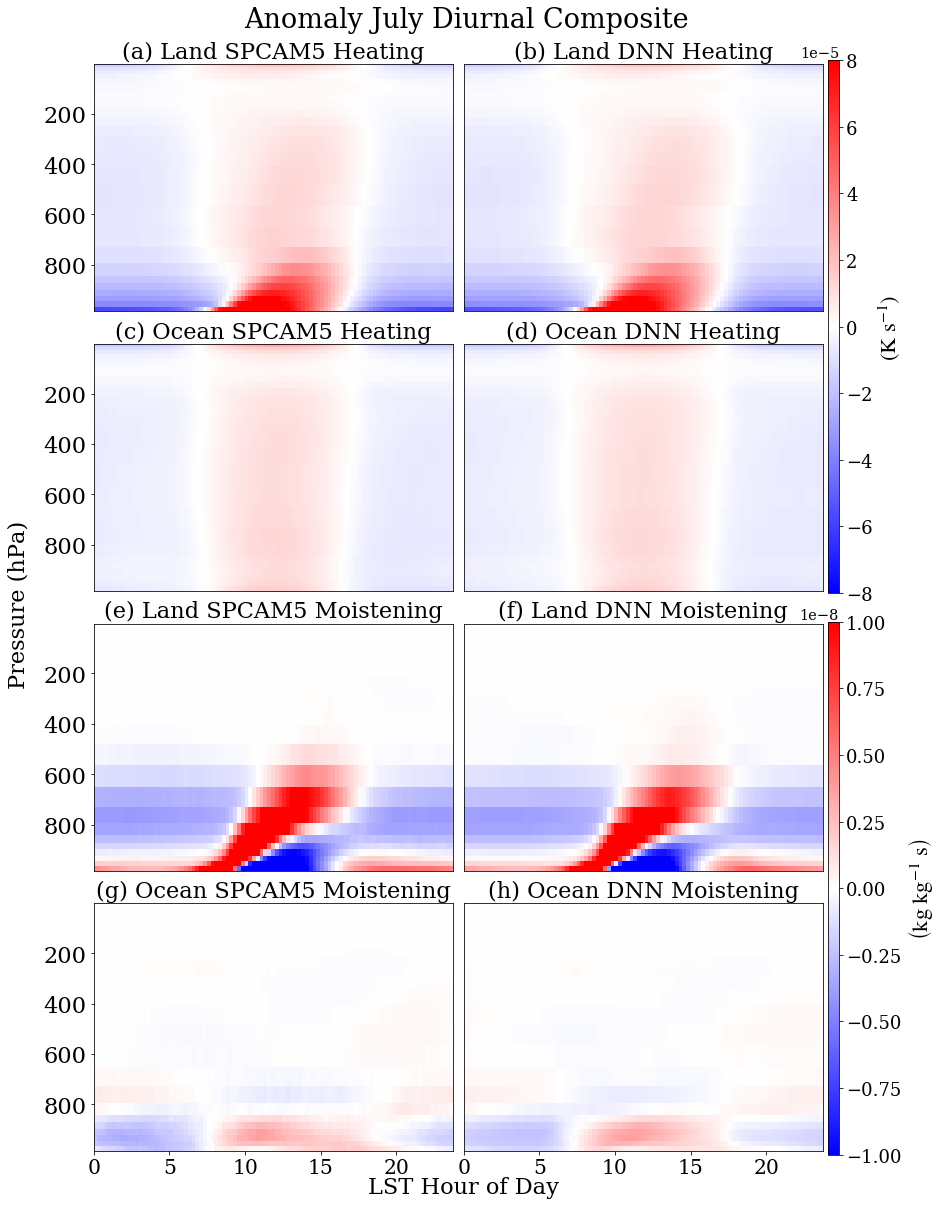

In [90]:
fig, ax = plt.subplots(4,2, figsize=(15,20))

cp = ax[0,0].pcolor(T, Z, anon_land_heat_SPCAM5_composite.T, cmap = 'bwr', vmin = -8.0e-5, vmax=8.0e-5)
ax[0,0].set_title("(a) Land SPCAM5 Heating", fontsize = fz)
ax[0,0].locator_params(nbins=8)
ax[0,0].tick_params(axis='x', labelsize=fz*0.9)
ax[0,0].set_ylim(ax[0,0].get_ylim()[::-1])
ax[0,0].set_xticks([])

cp = ax[0,1].pcolor(T, Z, anon_land_heat_DNN_composite.T, cmap = 'bwr', vmin = -8.0e-5, vmax=8.0e-5)
ax[0,1].set_title("(b) Land DNN Heating", fontsize = fz)
ax[0,1].set_ylim(ax[0,1].get_ylim()[::-1])
ax[0,1].set_yticks([])
ax[0,1].set_xticks([])
#ax[1,1].set_xlabel("Hour of Day")
#ax[1,1].xaxis.set_label_coords(-0.001,-0.10)
ax[0,1].locator_params(nbins=8)
ax[0,1].tick_params(axis='x', labelsize=fz*0.9)

cp = ax[1,0].pcolor(T, Z, anon_ocean_heat_SPCAM5_composite.T, cmap = 'bwr', vmin = -8.0e-5, vmax=8.0e-5)
ax[1,0].set_title("(c) Ocean SPCAM5 Heating", fontsize = fz)
ax[1,0].set_ylim(ax[1,0].get_ylim()[::-1])
ax[1,0].locator_params(nbins=8)
ax[1,0].tick_params(axis='x', labelsize=fz*0.9)
ax[1,0].set_xticks([])

cp = ax[1,1].pcolor(T, Z, anon_ocean_heat_DNN_composite.T, cmap = 'bwr', vmin = -8.0e-5, vmax=8.0e-5)
ax[1,1].set_title("(d) Ocean DNN Heating", fontsize = fz)
ax[1,1].set_ylim(ax[1,1].get_ylim()[::-1])
ax[1,1].set_yticks([])
ax[1,1].set_xticks([])
ax[1,1].set_ylabel("Pressure (hPa)")
ax[1,1].yaxis.set_label_coords(-1.21,-0.05)
ax[1,1].locator_params(nbins=8)
ax[1,1].tick_params(axis='x', labelsize=fz*0.9)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.5125, 0.01, 0.37])
cbar = fig.colorbar(cp, label=r'$\left(\mathrm{K} \ \mathrm{s^{-1}}\right)$', cax=cbar_ax)
cbar.ax.tick_params(labelsize=fz*0.8) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)
#register_bottom_offset(cbar.ax.yaxis, bottom_offset)

cp = ax[2,0].pcolor(T, Z, anon_land_moist_SPCAM5_composite.T, cmap = 'bwr', vmin=-1e-8, vmax=1e-8)
ax[2,0].set_title("(e) Land SPCAM5 Moistening", fontsize = fz)
ax[2,0].locator_params(nbins=8)
ax[2,0].tick_params(axis='x', labelsize=fz*0.9)
ax[2,0].set_ylim(ax[2,0].get_ylim()[::-1])
#ax[2,0].set_yticks([])
ax[2,0].set_xticks([])

cp = ax[2,1].pcolor(T, Z, anon_land_moist_DNN_composite.T, cmap = 'bwr', vmin=-1e-8, vmax=1e-8)
ax[2,1].set_title("(f) Land DNN Moistening", fontsize = fz)
ax[2,1].set_ylim(ax[2,1].get_ylim()[::-1])
ax[2,1].set_yticks([])
ax[3,1].set_xlabel("LST Hour of Day")
ax[3,1].xaxis.set_label_coords(-0.0,-0.10)
ax[2,1].locator_params(nbins=8)
ax[2,1].tick_params(axis='x', labelsize=fz*0.9)
ax[2,1].set_yticks([])
ax[2,1].set_xticks([])

cp = ax[3,0].pcolor(T, Z, anon_ocean_moist_SPCAM5_composite.T, cmap = 'bwr', vmin=-1e-8, vmax=1e-8)
ax[3,0].set_title("(g) Ocean SPCAM5 Moistening", fontsize = fz)
ax[3,0].set_ylim(ax[3,0].get_ylim()[::-1])
ax[3,0].locator_params(nbins=8)
ax[3,0].tick_params(axis='x', labelsize=fz*0.9)
#ax[3,0].set_xticks([])

cp = ax[3,1].pcolor(T, Z, anon_ocean_moist_DNN_composite.T, cmap = 'bwr', vmin=-1e-8, vmax=1e-8)
ax[3,1].set_title("(h) Ocean DNN Moistening", fontsize = fz)
ax[3,1].set_ylim(ax[3,1].get_ylim()[::-1])
ax[3,1].set_yticks([])
#ax[3,1].set_xticks([])
#ax[1,1].set_xlabel("Hour of Day")
#ax[1,1].xaxis.set_label_coords(-0.10,-0.10)
ax[3,1].locator_params(nbins=8)
ax[3,1].tick_params(axis='x', labelsize=fz*0.9)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.1225, 0.01, 0.37])
cbar = fig.colorbar(cp, label=r'$\left(\mathrm{kg} \ \mathrm{kg^{-1}} \ \mathrm{s}\right)$', cax=cbar_ax)
cbar.ax.tick_params(labelsize=fz*0.8) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)
#register_bottom_offset(cbar.ax.yaxis, bottom_offset)

plt.suptitle("Anomaly July Diurnal Composite", y = 0.92, x=0.47)
plt.subplots_adjust(hspace=0.13, wspace=0.03)
plt.savefig("Figures/Figure13.png")
plt.savefig("Figures/Figure13.pdf")

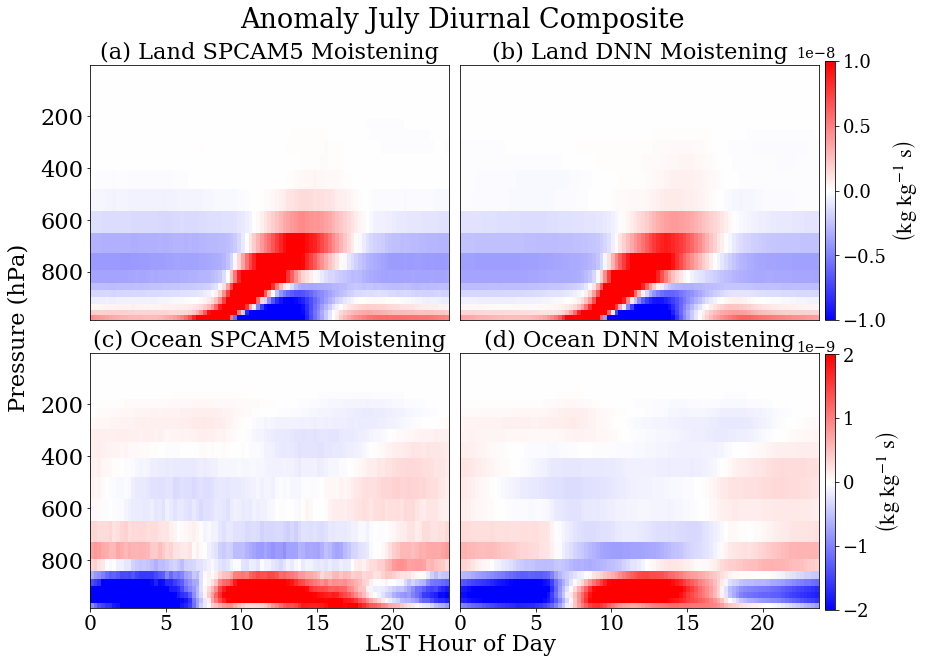

In [91]:
fig, ax = plt.subplots(2,2, figsize=(15,10))


cp = ax[0,0].pcolor(T, Z, anon_land_moist_SPCAM5_composite.T, cmap = 'bwr', vmin=-1e-8, vmax=1e-8)
ax[0,0].set_title("(a) Land SPCAM5 Moistening", fontsize = fz)
ax[0,0].locator_params(nbins=8)
ax[0,0].tick_params(axis='x', labelsize=fz*0.9)
ax[0,0].set_ylim(ax[0,0].get_ylim()[::-1])
ax[0,0].set_xticks([])

cp = ax[0,1].pcolor(T, Z, anon_land_moist_DNN_composite.T, cmap = 'bwr', vmin=-1e-8, vmax=1e-8)
ax[0,1].set_title("(b) Land DNN Moistening", fontsize = fz)
ax[0,1].set_ylim(ax[0,1].get_ylim()[::-1])
ax[0,1].set_yticks([])
ax[0,1].set_xticks([])


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.525, 0.01, 0.36])
cbar = fig.colorbar(cp, label=r'$\left(\mathrm{kg} \ \mathrm{kg^{-1}} \ \mathrm{s}\right)$', cax=cbar_ax)
cbar.ax.tick_params(labelsize=fz*0.8) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)
#register_bottom_offset(cbar.ax.yaxis, bottom_offset)


ax[1,1].set_xlabel("LST Hour of Day")
ax[1,1].xaxis.set_label_coords(-0.0,-0.10)
ax[1,1].locator_params(nbins=8)
ax[1,1].tick_params(axis='x', labelsize=fz*0.9)
ax[1,1].set_yticks([])

cp = ax[1,0].pcolor(T, Z, anon_ocean_moist_SPCAM5_composite.T, cmap = 'bwr', vmin=-2e-9, vmax=2e-9)
ax[1,0].set_title("(c) Ocean SPCAM5 Moistening", fontsize = fz)
ax[1,0].set_ylim(ax[1,0].get_ylim()[::-1])
ax[1,0].locator_params(nbins=8)
ax[1,0].tick_params(axis='x', labelsize=fz*0.9)

cp = ax[1,1].pcolor(T, Z, anon_ocean_moist_DNN_composite.T, cmap = 'bwr', vmin=-2e-9, vmax=2e-9)
ax[1,1].set_title("(d) Ocean DNN Moistening", fontsize = fz)
ax[1,1].set_ylim(ax[1,1].get_ylim()[::-1])
ax[1,1].set_yticks([])
ax[1,1].locator_params(nbins=8)
ax[1,1].tick_params(axis='x', labelsize=fz*0.9)
ax[1,1].set_ylabel("Pressure (hPa)")
ax[1,1].yaxis.set_label_coords(-1.2,1.1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.1225, 0.01, 0.355])
cbar = fig.colorbar(cp, label=r'$\left(\mathrm{kg} \ \mathrm{kg^{-1}} \ \mathrm{s}\right)$', cax=cbar_ax)
cbar.ax.tick_params(labelsize=fz*0.8) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*0.65)
#register_bottom_offset(cbar.ax.yaxis, bottom_offset)

plt.suptitle("Anomaly July Diurnal Composite", y = 0.96, x=0.47)
plt.subplots_adjust(hspace=0.13, wspace=0.03)
plt.savefig("Figures/Figure13.png")
plt.savefig("Figures/Figure13.pdf")